In [1]:
# Crypto Relative Value Strategy Research - Part 1: Setup & Data Loading
# =============================================================================

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import glob
from pathlib import Path
import warnings
from typing import Dict, List, Tuple, Optional, Any
from tqdm import tqdm
import statsmodels.api as sm
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import os
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import multiprocessing as mp
from functools import partial
import time

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# =============================================================================
# ENHANCED CONFIGURATION WITH PARALLELISM
# =============================================================================

class Config:
    # Data parameters
    FREQ_MINUTES = 5
    BARS_PER_DAY = 288  # 24 * 60 // FREQ_MINUTES
    
    # Rolling window parameters
    LOOKBACK_DAYS = 30
    LOOKBACK_BARS = LOOKBACK_DAYS * BARS_PER_DAY
    
    # Forward return parameters
    FORWARD_RETURN_PERIODS = [12, 24, 48, 96, 288]  # 1h, 2h, 4h, 8h, 24h
    
    # Signal parameters
    SIGNAL_THRESHOLDS = {
        'extreme': 2.5,
        'strong': 2.0,
        'moderate': 1.5,
        'weak': 1.0
    }
    
    # Strategy parameters
    STRATEGY_TYPES = ['mean_reversion', 'momentum', 'hybrid']
    HOLDING_PERIODS = [12, 24, 48, 96]  # Different exit timings
    
    # Ratio spread parameters
    SPREAD_TYPES = ['log_ratio', 'simple_ratio', 'normalized_ratio']
    
    # Symbols to analyze
    SYMBOLS = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
    
    # Analysis parameters
    MIN_OBSERVATIONS = 100
    CONFIDENCE_LEVEL = 0.95
    
    # Backtesting parameters
    INITIAL_CASH = 100000
    COMMISSION = 0.001  # 0.1% commission
    POSITION_SIZES = [0.05, 0.1, 0.15, 0.2]  # Different position sizes to test
    
    # Train-test split
    TRAIN_END_DATE = '2023-12-31'
    TEST_START_DATE = '2024-01-01'
    
    # Performance parameters
    MAX_WORKERS = min(8, mp.cpu_count())  # Use available CPUs
    CHUNK_SIZE = 5000  # Process data in chunks

config = Config()
print(f"Configuration loaded. Using {config.MAX_WORKERS} CPU cores for parallel processing.")

# =============================================================================
# PARALLEL DATA LOADING FUNCTIONS
# =============================================================================

def load_single_file(file_path: str) -> Optional[pl.DataFrame]:
    """Load a single CSV file - used for parallel processing"""
    try:
        schema = {
            'time': pl.Int64,
            'open': pl.Float64,
            'high': pl.Float64,
            'low': pl.Float64,
            'close': pl.Float64,
            'volume': pl.Float64
        }
        
        df = pl.read_csv(
            file_path,
            has_header=False,
            new_columns=list(schema.keys()),
            schema=schema,
            try_parse_dates=False
        )
        
        if not df.is_empty():
            return df
        return None
        
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def load_crypto_data_parallel(symbol: str, data_dir: str = "coinbase/5m") -> Optional[pl.DataFrame]:
    """Load crypto data using parallel processing for speed"""
    print(f"Loading data for {symbol} using parallel processing...")
    
    try:
        files = sorted(glob.glob(f"{data_dir}/*/{symbol}_5m_*.csv"))
        if not files:
            print(f"No files found for {symbol} in {data_dir}")
            return None
        
        print(f"Found {len(files)} files for {symbol}")
        
        # Load files in parallel
        start_time = time.time()
        with ThreadPoolExecutor(max_workers=config.MAX_WORKERS) as executor:
            dfs = list(tqdm(
                executor.map(load_single_file, files), 
                total=len(files), 
                desc=f"Loading {symbol}"
            ))
        
        # Filter out None results
        valid_dfs = [df for df in dfs if df is not None]
        
        if not valid_dfs:
            print(f"No valid data found for {symbol}")
            return None
        
        print(f"Concatenating {len(valid_dfs)} dataframes for {symbol}...")
        combined = pl.concat(valid_dfs, how="vertical")
        
        # Clean and prepare data
        result = (combined
                 .filter(pl.col('time').is_not_null() & pl.col('close').is_not_null())
                 .with_columns([
                     pl.from_epoch(pl.col('time'), time_unit='s').alias('datetime'),
                     pl.col('close').alias(f'close_{symbol.lower()}')
                 ])
                 .filter(pl.col('datetime').dt.year() >= 2023)
                 .sort('time')
                 .unique('time', keep='first')
                 )
        
        load_time = time.time() - start_time
        print(f"✓ Loaded {symbol}: {result.height:,} records in {load_time:.2f}s")
        print(f"  Date range: {result['datetime'].min()} to {result['datetime'].max()}")
        return result
        
    except Exception as e:
        print(f"Error loading {symbol}: {e}")
        return None

def create_time_aligned_data(symbol_data: Dict[str, pl.DataFrame]) -> pl.DataFrame:
    """Create time-aligned dataset with all symbols - optimized version"""
    if not symbol_data:
        raise ValueError("No symbol data provided")
    
    print("Creating time-aligned dataset...")
    
    # Find common time range
    min_time = max(df['time'].min() for df in symbol_data.values())
    max_time = min(df['time'].max() for df in symbol_data.values())
    
    print(f"Common time range: {min_time} to {max_time}")
    
    # Start with the first symbol's data as base
    first_symbol = list(symbol_data.keys())[0]
    result = (symbol_data[first_symbol]
              .filter((pl.col('time') >= min_time) & (pl.col('time') <= max_time))
              .select(['time', 'datetime', f'close_{first_symbol.lower()}'])
              )
    
    # Join other symbols using efficient method
    for symbol in list(symbol_data.keys())[1:]:
        print(f"Joining {symbol}...")
        symbol_df = (symbol_data[symbol]
                    .filter((pl.col('time') >= min_time) & (pl.col('time') <= max_time))
                    .select(['time', f'close_{symbol.lower()}'])
                    )
        result = result.join(symbol_df, on='time', how='inner')
    
    # Clean and sort
    result = result.sort('time').drop_nulls()
    
    print(f"✓ Time-aligned dataset: {result.height:,} records with {len(result.columns)} columns")
    return result

# =============================================================================
# MAIN DATA LOADING EXECUTION
# =============================================================================

def load_all_crypto_data() -> pl.DataFrame:
    """Load all cryptocurrency data with parallel processing"""
    
    print("CRYPTO RELATIVE VALUE STRATEGY RESEARCH")
    print("="*60)
    print(f"Configuration:")
    print(f"   Symbols: {config.SYMBOLS}")
    print(f"   Lookback: {config.LOOKBACK_DAYS} days ({config.LOOKBACK_BARS} bars)")
    print(f"   Forward periods: {config.FORWARD_RETURN_PERIODS} bars")
    print(f"   Signal thresholds: {config.SIGNAL_THRESHOLDS}")
    print(f"   Parallel workers: {config.MAX_WORKERS}")
    print()
    
    # Load data for all symbols in parallel
    print("STEP 1: Loading cryptocurrency data in parallel...")
    start_time = time.time()
    
    symbol_data = {}
    
    # Use ProcessPoolExecutor for CPU-intensive file operations
    load_func = partial(load_crypto_data_parallel, data_dir="coinbase/5m")
    
    with ThreadPoolExecutor(max_workers=min(4, len(config.SYMBOLS))) as executor:
        # Submit all symbol loading tasks
        future_to_symbol = {
            executor.submit(load_func, symbol): symbol 
            for symbol in config.SYMBOLS
        }
        
        # Collect results
        for future in tqdm(future_to_symbol, desc="Loading symbols"):
            symbol = future_to_symbol[future]
            try:
                df = future.result()
                if df is not None and not df.is_empty():
                    symbol_data[symbol] = df
                    print(f"✓ Successfully loaded {symbol}")
                else:
                    print(f"✗ Failed to load {symbol}")
            except Exception as e:
                print(f"✗ Error loading {symbol}: {e}")
    
    if len(symbol_data) < 2:
        raise ValueError("Need at least 2 symbols with data for spread analysis")
    
    total_load_time = time.time() - start_time
    print(f"\n✓ Successfully loaded {len(symbol_data)} symbols in {total_load_time:.2f}s")
    print(f"  Symbols: {list(symbol_data.keys())}")
    
    # Create time-aligned dataset
    print("\nSTEP 2: Creating time-aligned dataset...")
    aligned_df = create_time_aligned_data(symbol_data)
    
    return aligned_df

# Execute data loading
if __name__ == "__main__":
    # Load the data
    crypto_data = load_all_crypto_data()
    print(f"\nData loading complete!")
    print(f"Final dataset shape: {crypto_data.shape}")
    print(f"Date range: {crypto_data['datetime'].min()} to {crypto_data['datetime'].max()}")
    print(f"Available columns: {crypto_data.columns}")

Configuration loaded. Using 8 CPU cores for parallel processing.
CRYPTO RELATIVE VALUE STRATEGY RESEARCH
Configuration:
   Symbols: ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
   Lookback: 30 days (8640 bars)
   Forward periods: [12, 24, 48, 96, 288] bars
   Signal thresholds: {'extreme': 2.5, 'strong': 2.0, 'moderate': 1.5, 'weak': 1.0}
   Parallel workers: 8

STEP 1: Loading cryptocurrency data in parallel...
Loading data for BTCUSD using parallel processing...
Loading data for ETHUSD using parallel processing...
Loading data for SOLUSD using parallel processing...
Loading data for XRPUSD using parallel processing...


Loading symbols:   0%|          | 0/4 [00:00<?, ?it/s]

Found 10 files for BTCUSD
Found 10 files for ETHUSD
Found 3 files for XRPUSD
Found 5 files for SOLUSD



Loading BTCUSD: 100%|██████████| 10/10 [00:00<00:00, 377.42it/s]


Concatenating 3 dataframes for XRPUSD...
Concatenating 10 dataframes for BTCUSD...



Loading ETHUSD: 100%|██████████| 10/10 [00:00<00:00, 1809.92it/s]

Concatenating 5 dataframes for SOLUSD...
Concatenating 10 dataframes for ETHUSD...
✓ Loaded XRPUSD: 220,633 records in 0.18s
  Date range: 2023-07-13 15:00:00 to 2025-08-17 17:00:00



Loading symbols: 100%|██████████| 4/4 [00:00<00:00, 13.29it/s]

✓ Loaded SOLUSD: 276,397 records in 0.22s
  Date range: 2023-01-01 00:00:00 to 2025-08-17 17:00:00
✓ Loaded BTCUSD: 276,377 records in 0.26s
  Date range: 2023-01-01 00:00:00 to 2025-08-17 15:20:00
✓ Successfully loaded BTCUSD
✓ Loaded ETHUSD: 276,378 records in 0.29s
  Date range: 2023-01-01 00:00:00 to 2025-08-17 15:25:00
✓ Successfully loaded ETHUSD
✓ Successfully loaded SOLUSD
✓ Successfully loaded XRPUSD

✓ Successfully loaded 4 symbols in 0.31s
  Symbols: ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']

STEP 2: Creating time-aligned dataset...
Creating time-aligned dataset...
Common time range: 1689260400 to 1755444000
Joining ETHUSD...
Joining SOLUSD...
Joining XRPUSD...
✓ Time-aligned dataset: 220,613 records with 6 columns

Data loading complete!
Final dataset shape: (220613, 6)
Date range: 2023-07-13 15:00:00 to 2025-08-17 15:20:00
Available columns: ['time', 'datetime', 'close_btcusd', 'close_ethusd', 'close_solusd', 'close_xrpusd']



STEP 3: COMPREHENSIVE EXPLORATORY DATA ANALYSIS
EDA initialized with 220,613 records and 4 symbols
Memory usage: 10.10 MB

3.1 Creating comprehensive overview plots...
Creating comprehensive market overview...


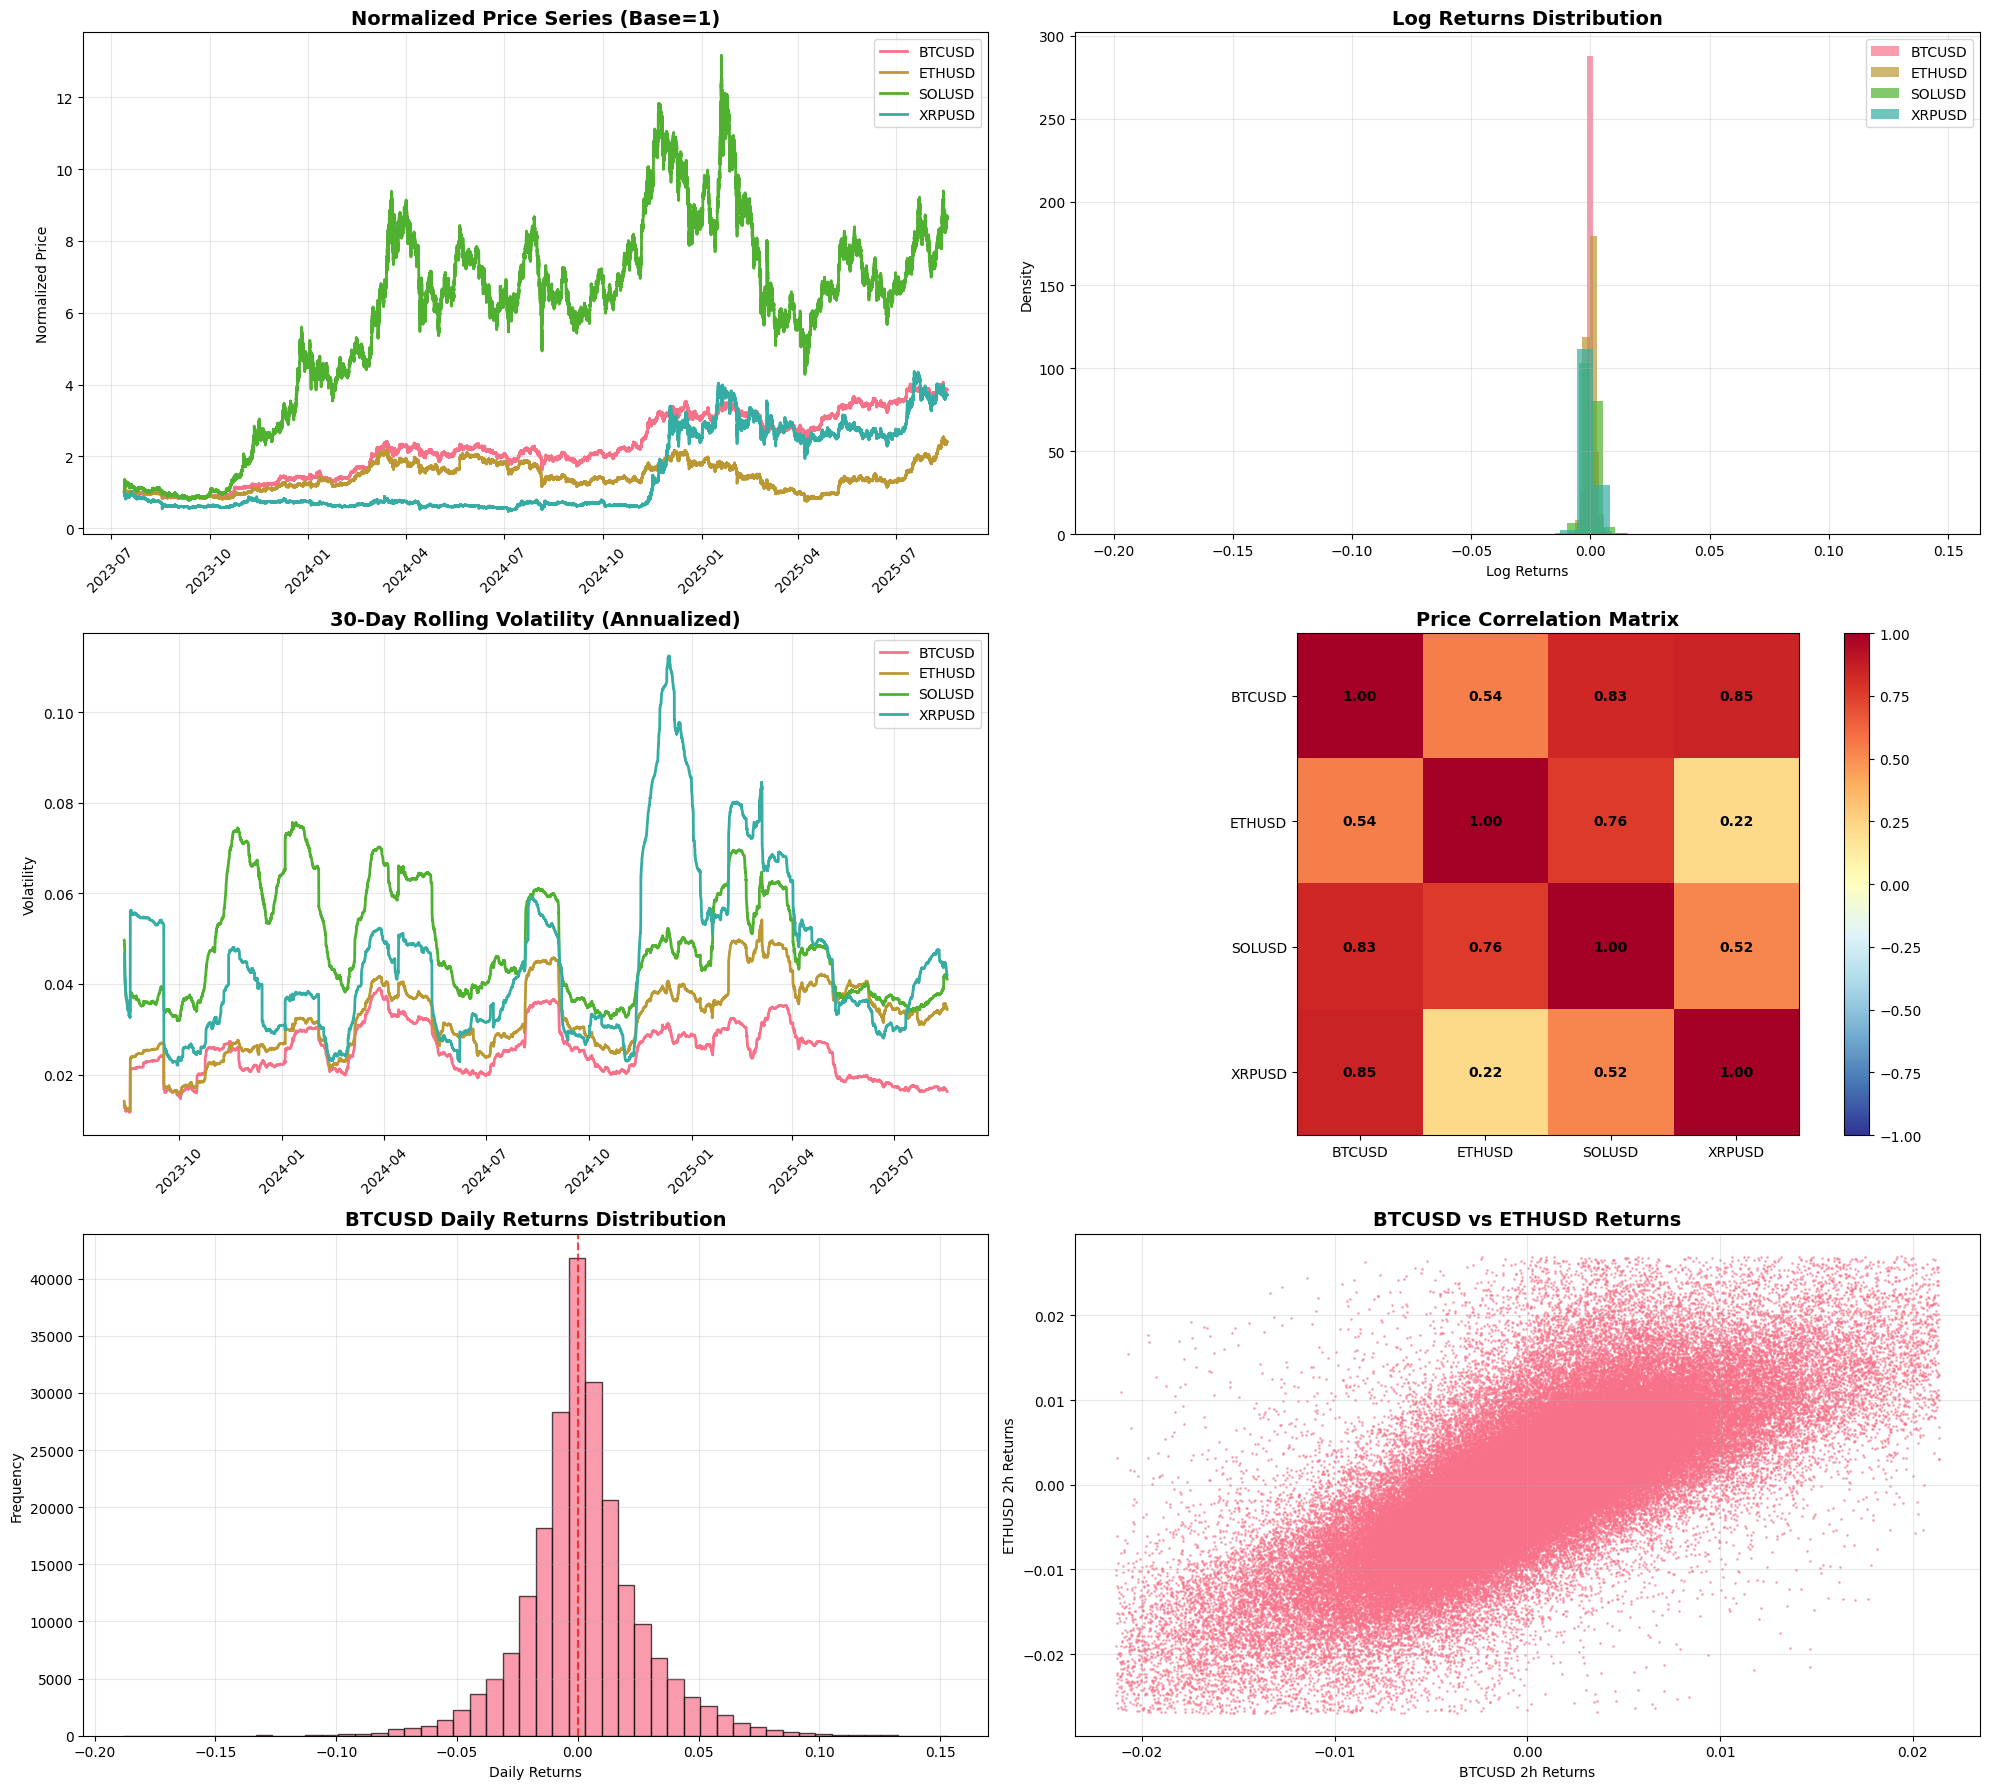


3.2 Analyzing market regimes...
Analyzing market regimes...


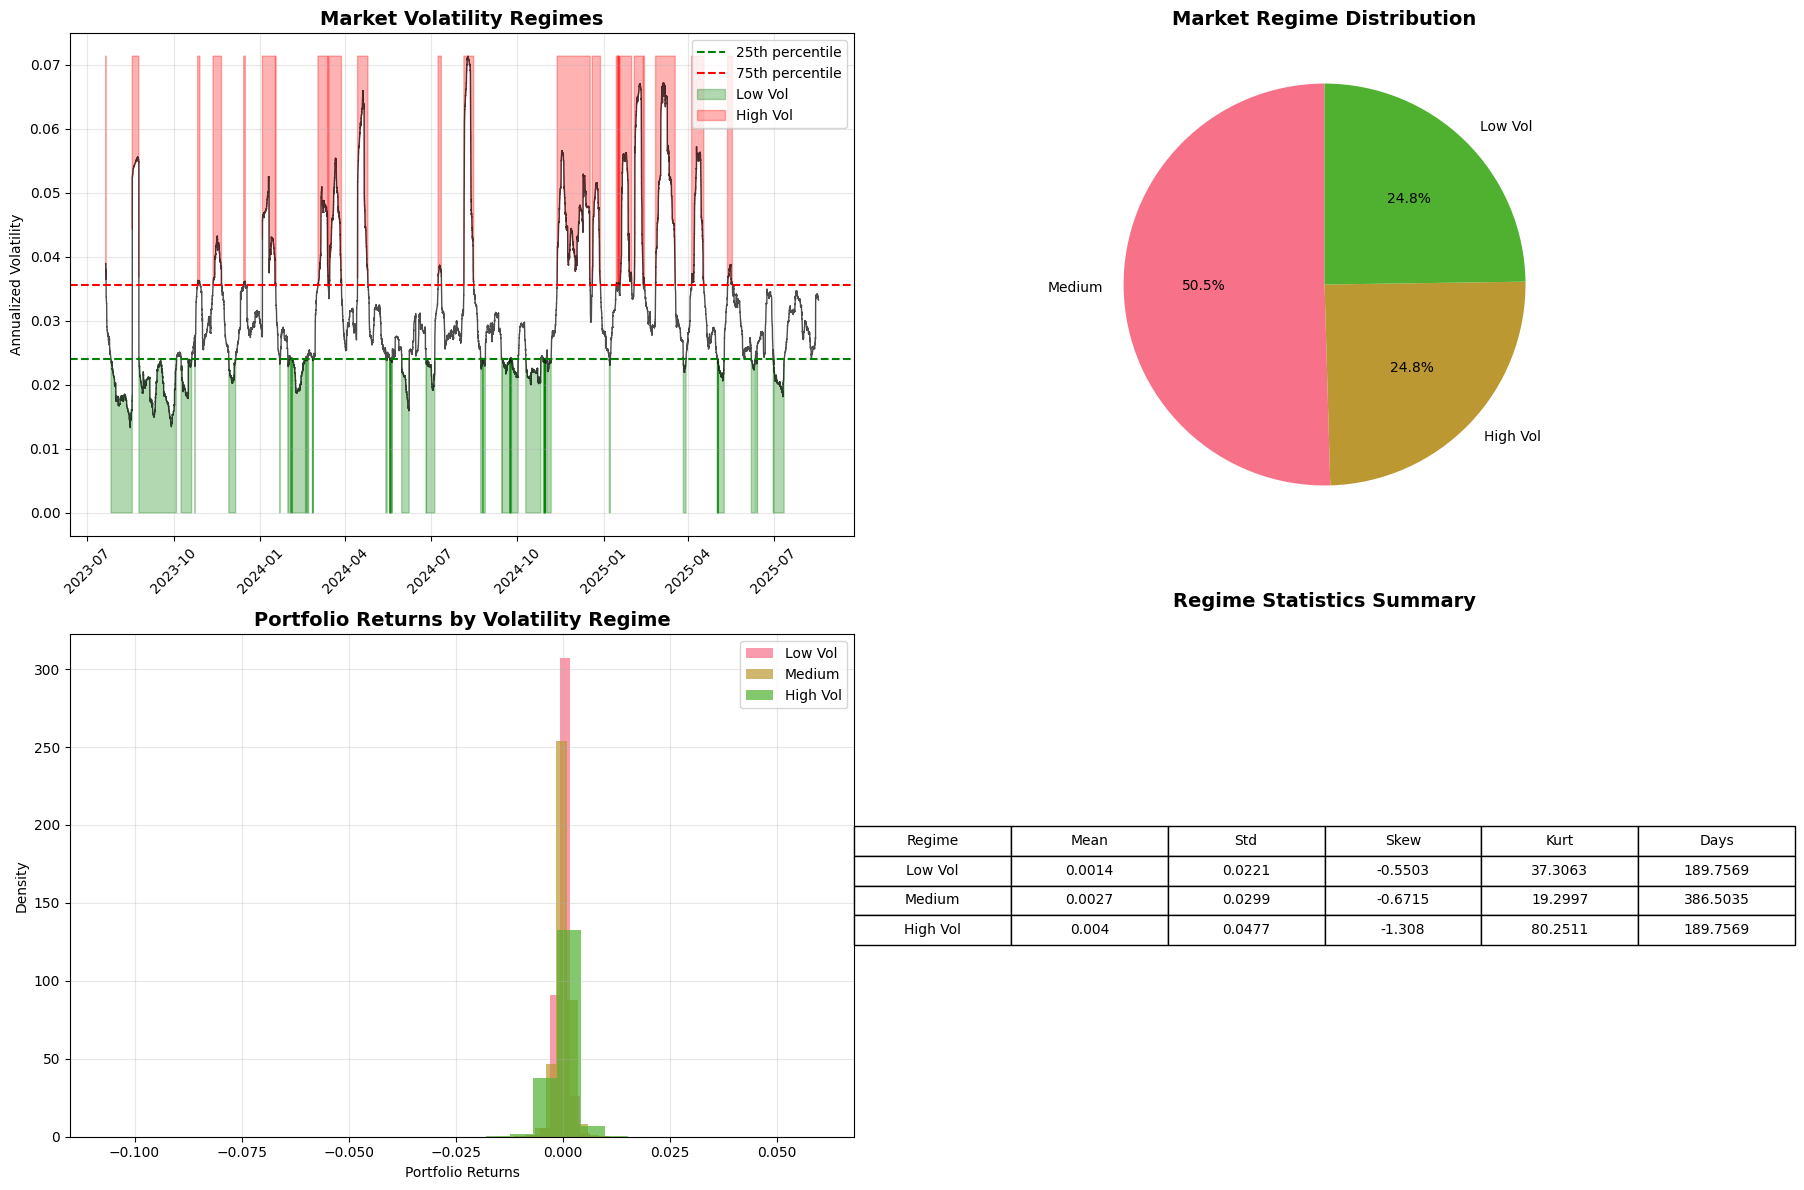


3.3 Analyzing correlation stability...
Analyzing correlation stability...


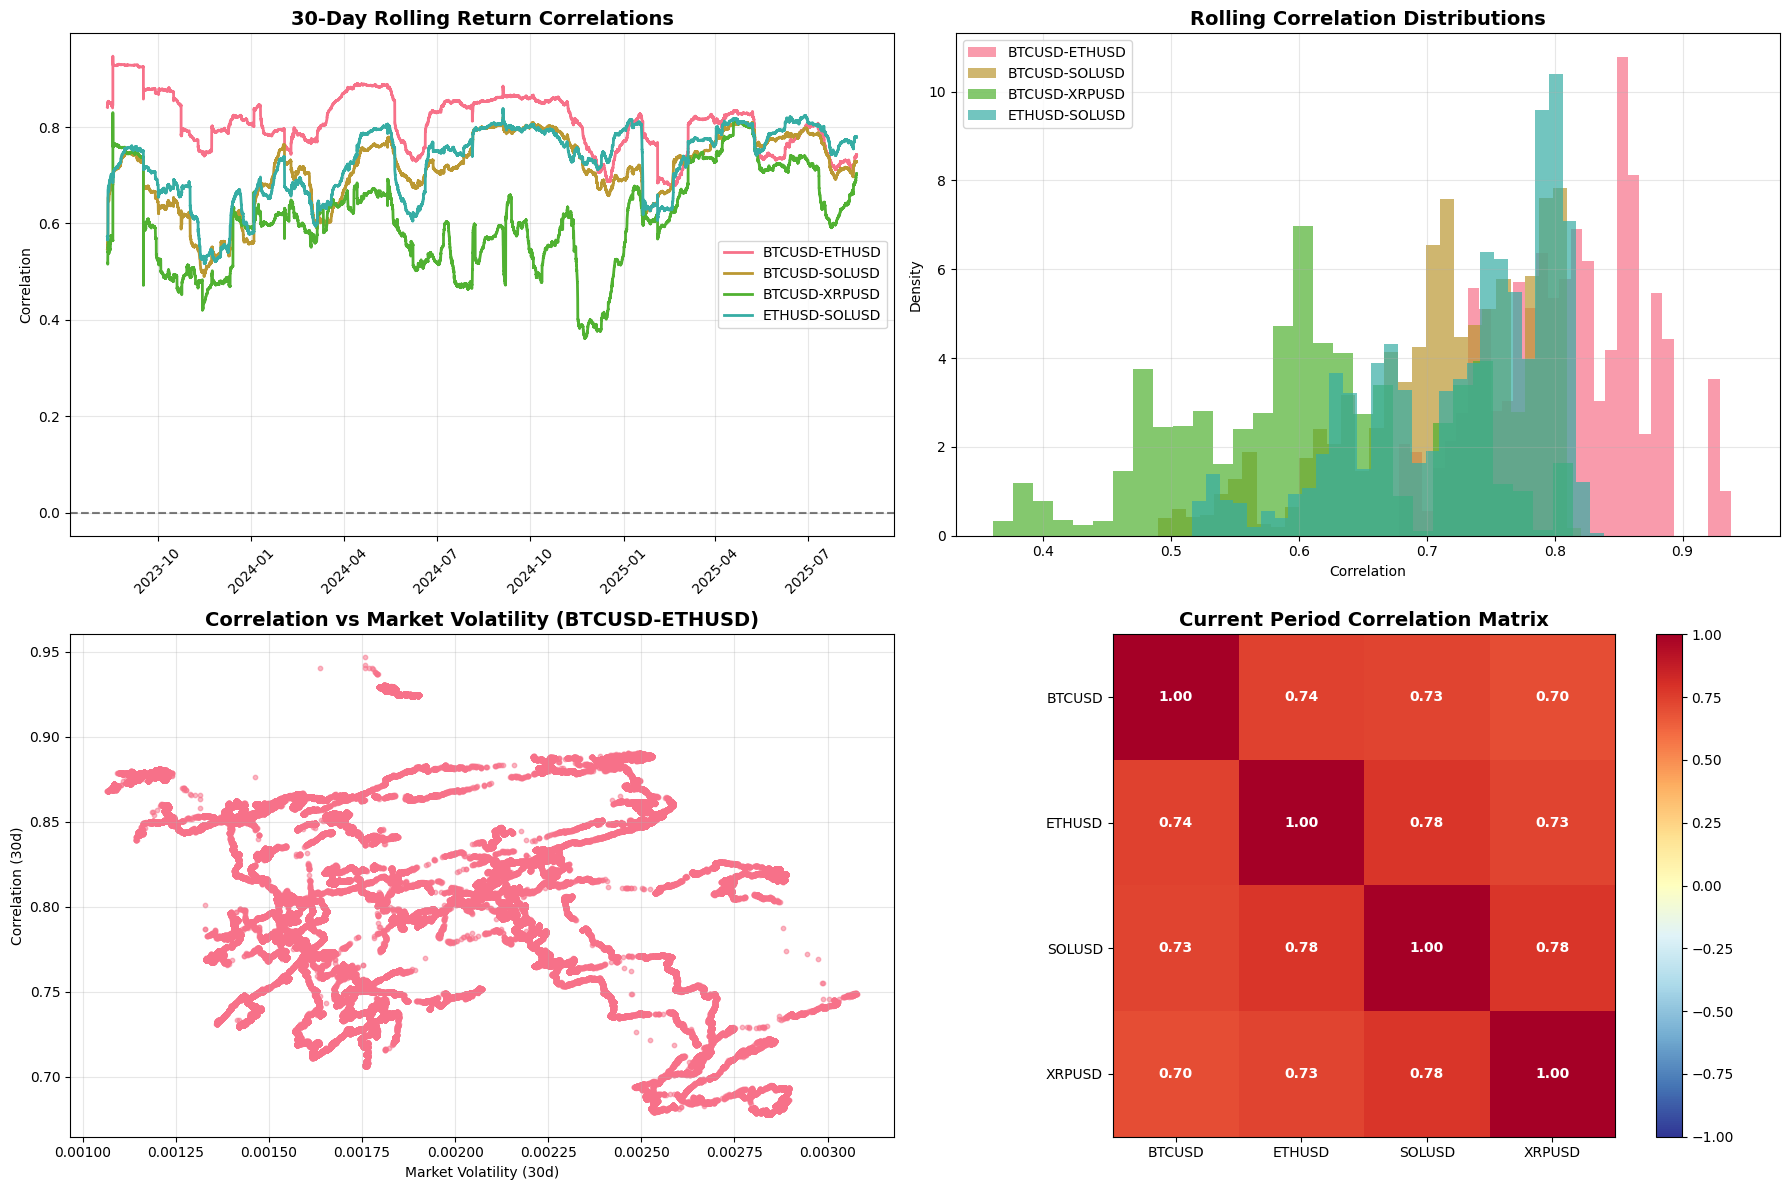


3.4 Generating comprehensive summary statistics...
Generating comprehensive summary statistics...

BASIC STATISTICS
Symbol Start_Date   End_Date  Observations  Start_Price   End_Price  Min_Price   Max_Price  Mean_Price  Price_Std
BTCUSD 2023-07-13 2025-08-17        220589    30576.430 118211.8100 24997.2000 124301.5600  68588.2809 27313.5292
ETHUSD 2023-07-13 2025-08-17        220580     1882.510   4547.2000  1397.3400   4785.2400   2663.2975   709.8141
SOLUSD 2023-07-13 2025-08-17        220572       22.330    193.7600    17.4400    294.1700    132.4735    60.5084
XRPUSD 2023-07-13 2025-08-17        220498        0.839      3.1166     0.3882      3.6588      1.2284     0.9292

PERFORMANCE STATISTICS
Symbol  Total_Return_%  Daily_Return_%  Daily_Volatility_%  Sharpe_Ratio  Max_Drawdown_%  Calmar_Ratio
BTCUSD          286.61          0.2092                2.55        0.0819          -33.01        8.6838
ETHUSD          141.55          0.1712                3.34        0.0512          -

In [2]:
# Crypto Relative Value Strategy Research - Part 2: Exploratory Data Analysis
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

class EnhancedCryptoEDA:
    """Enhanced EDA class with parallel processing and comprehensive analysis"""
    
    def __init__(self, df: pl.DataFrame, symbols: List[str]):
        self.df = df
        self.symbols = symbols
        self.df_pd = df.to_pandas()  # Convert once for plotting
        print(f"EDA initialized with {df.height:,} records and {len(symbols)} symbols")
        print(f"Memory usage: {self.df_pd.memory_usage().sum() / 1024**2:.2f} MB")
    
    def plot_comprehensive_overview(self):
        """Create comprehensive overview plots"""
        print("Creating comprehensive market overview...")
        
        fig, axes = plt.subplots(3, 2, figsize=(20, 18))
        
        # 1. Normalized Price Series
        ax = axes[0, 0]
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col in self.df_pd.columns and len(self.df_pd[col].dropna()) > 0:
                first_price = self.df_pd[col].dropna().iloc[0]
                normalized_prices = self.df_pd[col] / first_price
                ax.plot(self.df_pd['datetime'], normalized_prices, label=symbol, linewidth=2)
        
        ax.set_title('Normalized Price Series (Base=1)', fontsize=14, fontweight='bold')
        ax.set_ylabel('Normalized Price')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # 2. Log Returns Distribution
        ax = axes[0, 1]
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col in self.df_pd.columns:
                returns = np.log(self.df_pd[col] / self.df_pd[col].shift(1)).dropna()
                ax.hist(returns, bins=50, alpha=0.7, label=symbol, density=True)
        
        ax.set_title('Log Returns Distribution', fontsize=14, fontweight='bold')
        ax.set_xlabel('Log Returns')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Rolling Volatility (30-day)
        ax = axes[1, 0]
        window = 30 * config.BARS_PER_DAY
        
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col in self.df_pd.columns:
                returns = self.df_pd[col].pct_change()
                rolling_vol = returns.rolling(window=window).std() * np.sqrt(config.BARS_PER_DAY)
                ax.plot(self.df_pd['datetime'], rolling_vol, label=f'{symbol}', linewidth=2)
        
        ax.set_title('30-Day Rolling Volatility (Annualized)', fontsize=14, fontweight='bold')
        ax.set_ylabel('Volatility')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # 4. Price Correlation Heatmap
        ax = axes[1, 1]
        price_data = {}
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col in self.df_pd.columns:
                price_data[symbol] = self.df_pd[col]
        
        if price_data:
            price_corr = pd.DataFrame(price_data).corr()
            im = ax.imshow(price_corr.values, cmap='RdYlBu_r', vmin=-1, vmax=1)
            ax.set_xticks(range(len(self.symbols)))
            ax.set_yticks(range(len(self.symbols)))
            ax.set_xticklabels(self.symbols)
            ax.set_yticklabels(self.symbols)
            
            # Add correlation values
            for i in range(len(self.symbols)):
                for j in range(len(self.symbols)):
                    ax.text(j, i, f'{price_corr.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')
            
            ax.set_title('Price Correlation Matrix', fontsize=14, fontweight='bold')
            plt.colorbar(im, ax=ax)
        
        # 5. Daily Returns vs Volume
        ax = axes[2, 0]
        if len(self.symbols) >= 2:
            symbol1, symbol2 = self.symbols[0], self.symbols[1]
            col1 = f'close_{symbol1.lower()}'
            
            if col1 in self.df_pd.columns:
                daily_returns = self.df_pd[col1].pct_change(config.BARS_PER_DAY)  # Daily returns
                ax.hist(daily_returns.dropna(), bins=50, alpha=0.7, edgecolor='black')
                ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)
                ax.set_title(f'{symbol1} Daily Returns Distribution', fontsize=14, fontweight='bold')
                ax.set_xlabel('Daily Returns')
                ax.set_ylabel('Frequency')
                ax.grid(True, alpha=0.3)
        
        # 6. Cross-asset momentum correlation
        ax = axes[2, 1]
        if len(self.symbols) >= 2:
            col1 = f'close_{self.symbols[0].lower()}'
            col2 = f'close_{self.symbols[1].lower()}'
            
            if col1 in self.df_pd.columns and col2 in self.df_pd.columns:
                ret1 = self.df_pd[col1].pct_change(24)  # 2-hour returns
                ret2 = self.df_pd[col2].pct_change(24)
                
                # Remove outliers for better visualization
                # ret1_clean = ret1[(ret1.abs() < ret1.quantile(0.99))]
                # ret2_clean = ret2[(ret2.abs() < ret2.quantile(0.99))]

                mask = (ret1.abs() < ret1.quantile(0.99)) & (ret2.abs() < ret2.quantile(0.99))
                ret1_clean = ret1[mask]
                ret2_clean = ret2[mask]
                
                ax.scatter(ret1_clean, ret2_clean, alpha=0.5, s=1)
                ax.set_xlabel(f'{self.symbols[0]} 2h Returns')
                ax.set_ylabel(f'{self.symbols[1]} 2h Returns')
                ax.set_title(f'{self.symbols[0]} vs {self.symbols[1]} Returns', fontsize=14, fontweight='bold')
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_market_regimes(self):
        """Analyze different market regimes based on volatility"""
        print("Analyzing market regimes...")
        
        # Calculate market-wide volatility using equal-weighted portfolio
        portfolio_returns = pd.Series(0, index=self.df_pd.index)
        weights = 1.0 / len(self.symbols)
        
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col in self.df_pd.columns:
                returns = self.df_pd[col].pct_change().fillna(0)
                portfolio_returns += weights * returns
        
        # Calculate rolling volatility
        vol_window = 7 * config.BARS_PER_DAY  # 7-day window
        rolling_vol = portfolio_returns.rolling(window=vol_window).std() * np.sqrt(config.BARS_PER_DAY)
        
        # Define regimes based on volatility quantiles
        vol_25 = rolling_vol.quantile(0.25)
        vol_75 = rolling_vol.quantile(0.75)
        
        regimes = pd.Series('Medium', index=self.df_pd.index)
        regimes[rolling_vol <= vol_25] = 'Low Vol'
        regimes[rolling_vol >= vol_75] = 'High Vol'
        
        # Plot regime analysis
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        
        # 1. Volatility time series with regimes
        ax = axes[0, 0]
        ax.plot(self.df_pd['datetime'], rolling_vol, linewidth=1, color='black', alpha=0.7)
        ax.axhline(y=vol_25, color='green', linestyle='--', label='25th percentile')
        ax.axhline(y=vol_75, color='red', linestyle='--', label='75th percentile')
        ax.fill_between(self.df_pd['datetime'], 0, rolling_vol, 
                       where=(rolling_vol <= vol_25), alpha=0.3, color='green', label='Low Vol')
        ax.fill_between(self.df_pd['datetime'], rolling_vol, rolling_vol.max(), 
                       where=(rolling_vol >= vol_75), alpha=0.3, color='red', label='High Vol')
        ax.set_title('Market Volatility Regimes', fontsize=14, fontweight='bold')
        ax.set_ylabel('Annualized Volatility')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # 2. Regime distribution
        ax = axes[0, 1]
        regime_counts = regimes.value_counts()
        ax.pie(regime_counts.values, labels=regime_counts.index, autopct='%1.1f%%', startangle=90)
        ax.set_title('Market Regime Distribution', fontsize=14, fontweight='bold')
        
        # 3. Returns by regime
        ax = axes[1, 0]
        regime_returns = {}
        for regime in ['Low Vol', 'Medium', 'High Vol']:
            mask = regimes == regime
            if mask.sum() > 0:
                regime_ret = portfolio_returns[mask]
                regime_returns[regime] = regime_ret
                ax.hist(regime_ret, bins=30, alpha=0.7, label=regime, density=True)
        
        ax.set_title('Portfolio Returns by Volatility Regime', fontsize=14, fontweight='bold')
        ax.set_xlabel('Portfolio Returns')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Summary statistics by regime
        ax = axes[1, 1]
        if regime_returns:
            stats_data = []
            for regime, returns in regime_returns.items():
                stats_data.append({
                    'Regime': regime,
                    'Mean': returns.mean() * config.BARS_PER_DAY,  # Daily
                    'Std': returns.std() * np.sqrt(config.BARS_PER_DAY),  # Daily
                    'Skew': returns.skew(),
                    'Kurt': returns.kurtosis(),
                    'Days': len(returns) / config.BARS_PER_DAY
                })
            
            stats_df = pd.DataFrame(stats_data)
            
            # Create table
            ax.axis('tight')
            ax.axis('off')
            table = ax.table(cellText=stats_df.round(4).values,
                           colLabels=stats_df.columns,
                           cellLoc='center',
                           loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1.2, 1.5)
            ax.set_title('Regime Statistics Summary', fontsize=14, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
        
        return regimes
    
    def correlation_stability_analysis(self):
        """Analyze correlation stability over time"""
        print("Analyzing correlation stability...")
        
        if len(self.symbols) < 2:
            print("Need at least 2 symbols for correlation analysis")
            return
        
        # Get all pairs
        pairs = list(combinations(self.symbols, 2))
        
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        
        # Calculate rolling correlations for each pair
        window = 30 * config.BARS_PER_DAY  # 30-day rolling
        
        # 1. Rolling correlations time series
        ax = axes[0, 0]
        correlation_data = {}
        
        for sym1, sym2 in pairs[:4]:  # Limit to first 4 pairs for clarity
            col1 = f'close_{sym1.lower()}'
            col2 = f'close_{sym2.lower()}'
            
            if col1 in self.df_pd.columns and col2 in self.df_pd.columns:
                ret1 = self.df_pd[col1].pct_change()
                ret2 = self.df_pd[col2].pct_change()
                rolling_corr = ret1.rolling(window=window).corr(ret2)
                
                ax.plot(self.df_pd['datetime'], rolling_corr, label=f'{sym1}-{sym2}', linewidth=2)
                correlation_data[f'{sym1}-{sym2}'] = rolling_corr
        
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax.set_title('30-Day Rolling Return Correlations', fontsize=14, fontweight='bold')
        ax.set_ylabel('Correlation')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # 2. Correlation distribution
        ax = axes[0, 1]
        for pair_name, corr_series in correlation_data.items():
            ax.hist(corr_series.dropna(), bins=30, alpha=0.7, label=pair_name, density=True)
        
        ax.set_title('Rolling Correlation Distributions', fontsize=14, fontweight='bold')
        ax.set_xlabel('Correlation')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Correlation vs Market Stress (using portfolio volatility as proxy)
        ax = axes[1, 0]
        if correlation_data:
            # Use portfolio volatility as market stress indicator
            portfolio_returns = pd.Series(0, index=self.df_pd.index)
            for symbol in self.symbols:
                col = f'close_{symbol.lower()}'
                if col in self.df_pd.columns:
                    returns = self.df_pd[col].pct_change().fillna(0)
                    portfolio_returns += returns / len(self.symbols)
            
            market_vol = portfolio_returns.rolling(window=window).std()
            
            # Plot correlation vs volatility for first pair
            first_pair = list(correlation_data.keys())[0]
            first_corr = correlation_data[first_pair]
            
            mask = ~(first_corr.isna() | market_vol.isna())
            if mask.sum() > 100:  # Ensure we have enough data points
                ax.scatter(market_vol[mask], first_corr[mask], alpha=0.5, s=10)
                ax.set_xlabel('Market Volatility (30d)')
                ax.set_ylabel('Correlation (30d)')
                ax.set_title(f'Correlation vs Market Volatility ({first_pair})', fontsize=14, fontweight='bold')
                ax.grid(True, alpha=0.3)
        
        # 4. Correlation matrix heatmap (current period)
        ax = axes[1, 1]
        current_returns = {}
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col in self.df_pd.columns:
                returns = self.df_pd[col].pct_change().fillna(0)
                current_returns[symbol] = returns.tail(window)  # Last 30 days
        
        if current_returns:
            corr_matrix = pd.DataFrame(current_returns).corr()
            im = ax.imshow(corr_matrix.values, cmap='RdYlBu_r', vmin=-1, vmax=1)
            
            ax.set_xticks(range(len(self.symbols)))
            ax.set_yticks(range(len(self.symbols)))
            ax.set_xticklabels(self.symbols)
            ax.set_yticklabels(self.symbols)
            
            # Add correlation values
            for i in range(len(self.symbols)):
                for j in range(len(self.symbols)):
                    text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                                 ha="center", va="center", 
                                 color="white" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black",
                                 fontweight='bold')
            
            ax.set_title('Current Period Correlation Matrix', fontsize=14, fontweight='bold')
            plt.colorbar(im, ax=ax)
        
        plt.tight_layout()
        plt.show()
    
    def generate_comprehensive_summary(self) -> Dict[str, pd.DataFrame]:
        """Generate comprehensive summary statistics"""
        print("Generating comprehensive summary statistics...")
        
        # Basic statistics
        basic_stats = []
        performance_stats = []
        risk_stats = []
        
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col in self.df_pd.columns:
                prices = self.df_pd[col].dropna()
                if len(prices) > 0:
                    returns = prices.pct_change().fillna(0)
                    log_returns = np.log(prices / prices.shift(1)).fillna(0)
                    
                    # Basic stats
                    basic_stats.append({
                        'Symbol': symbol,
                        'Start_Date': str(self.df_pd['datetime'].min().date()),
                        'End_Date': str(self.df_pd['datetime'].max().date()),
                        'Observations': len(prices),
                        'Start_Price': round(prices.iloc[0], 4),
                        'End_Price': round(prices.iloc[-1], 4),
                        'Min_Price': round(prices.min(), 4),
                        'Max_Price': round(prices.max(), 4),
                        'Mean_Price': round(prices.mean(), 4),
                        'Price_Std': round(prices.std(), 4)
                    })
                    
                    # Performance stats
                    total_return = (prices.iloc[-1] / prices.iloc[0] - 1) * 100
                    daily_return = returns.mean() * config.BARS_PER_DAY * 100
                    daily_vol = returns.std() * np.sqrt(config.BARS_PER_DAY) * 100
                    sharpe = (returns.mean() / returns.std()) * np.sqrt(config.BARS_PER_DAY) if returns.std() > 0 else 0
                    
                    # Calculate max drawdown
                    cumulative = (1 + returns).cumprod()
                    running_max = cumulative.expanding().max()
                    drawdown = (cumulative - running_max) / running_max
                    max_drawdown = drawdown.min() * 100
                    
                    performance_stats.append({
                        'Symbol': symbol,
                        'Total_Return_%': round(total_return, 2),
                        'Daily_Return_%': round(daily_return, 4),
                        'Daily_Volatility_%': round(daily_vol, 2),
                        'Sharpe_Ratio': round(sharpe, 4),
                        'Max_Drawdown_%': round(max_drawdown, 2),
                        'Calmar_Ratio': round(total_return / abs(max_drawdown), 4) if max_drawdown != 0 else 0
                    })
                    
                    # Risk stats
                    var_95 = np.percentile(returns, 5) * 100
                    cvar_95 = returns[returns <= np.percentile(returns, 5)].mean() * 100
                    
                    risk_stats.append({
                        'Symbol': symbol,
                        'Skewness': round(returns.skew(), 4),
                        'Kurtosis': round(returns.kurtosis(), 4),
                        'VaR_95_%': round(var_95, 4),
                        'CVaR_95_%': round(cvar_95, 4),
                        'Positive_Days_%': round((returns > 0).mean() * 100, 2),
                        'Up_Capture': round(returns[returns > 0].mean() / returns.mean(), 4) if returns.mean() != 0 else 0,
                        'Down_Capture': round(returns[returns < 0].mean() / returns.mean(), 4) if returns.mean() != 0 else 0
                    })
        
        summary = {
            'basic_stats': pd.DataFrame(basic_stats),
            'performance_stats': pd.DataFrame(performance_stats),
            'risk_stats': pd.DataFrame(risk_stats)
        }
        
        # Display summaries
        print("\n" + "="*80)
        print("BASIC STATISTICS")
        print("="*80)
        print(summary['basic_stats'].to_string(index=False))
        
        print("\n" + "="*80)
        print("PERFORMANCE STATISTICS")
        print("="*80)
        print(summary['performance_stats'].to_string(index=False))
        
        print("\n" + "="*80)
        print("RISK STATISTICS")
        print("="*80)
        print(summary['risk_stats'].to_string(index=False))
        
        return summary

# =============================================================================
# RUN EDA
# =============================================================================

def run_comprehensive_eda(crypto_data: pl.DataFrame) -> Dict[str, Any]:
    """Run comprehensive EDA with all analysis components"""
    
    print("\nSTEP 3: COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
    print("="*60)
    
    # Extract symbols from column names
    symbols = [col.replace('close_', '').upper() for col in crypto_data.columns if col.startswith('close_')]
    
    # Initialize EDA
    eda = EnhancedCryptoEDA(crypto_data, symbols)
    
    # Run all EDA components
    print("\n3.1 Creating comprehensive overview plots...")
    eda.plot_comprehensive_overview()
    
    print("\n3.2 Analyzing market regimes...")
    regimes = eda.analyze_market_regimes()
    
    print("\n3.3 Analyzing correlation stability...")
    eda.correlation_stability_analysis()
    
    print("\n3.4 Generating comprehensive summary statistics...")
    summary_stats = eda.generate_comprehensive_summary()
    
    print("\n✓ EDA Complete!")
    
    return {
        'eda_object': eda,
        'market_regimes': regimes,
        'summary_stats': summary_stats,
        'symbols': symbols
    }

# Execute EDA if data is available
if __name__ == "__main__" and 'crypto_data' in locals():
    eda_results = run_comprehensive_eda(crypto_data)
    print("EDA results stored in 'eda_results' variable")
else:
    print("Run Part 1 first to load crypto_data")

In [3]:
# Crypto Relative Value Strategy Research - Part 3: Feature Engineering
# =============================================================================

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from functools import partial
import itertools

class ParallelFeatureEngineer:
    """Feature engineering with parallel processing for speed optimization"""
    
    def __init__(self, df: pl.DataFrame, symbols: List[str]):
        self.df = df
        self.symbols = symbols
        print(f"Feature Engineer initialized with {df.height:,} records and {len(symbols)} symbols")
    
    def split_train_test_safe(self) -> Tuple[pl.DataFrame, pl.DataFrame]:
        """Split data safely to prevent data leakage"""
        print("Splitting data into train/test sets (preventing data leakage)...")
        
        train_df = self.df.filter(pl.col('datetime') < datetime.strptime(config.TRAIN_END_DATE, "%Y-%m-%d"))
        test_df = self.df.filter(pl.col('datetime') >= datetime.strptime(config.TEST_START_DATE, "%Y-%m-%d"))
        
        print(f"Train set: {train_df.height:,} records ({train_df['datetime'].min()} to {train_df['datetime'].max()})")
        print(f"Test set: {test_df.height:,} records ({test_df['datetime'].min()} to {test_df['datetime'].max()})")
        
        return train_df, test_df
    
    def calculate_single_pair_ratios(self, pair_symbols: Tuple[str, str], df: pl.DataFrame) -> pl.DataFrame:
        """Calculate ratio spreads for a single pair - used for parallel processing"""
        sym1, sym2 = pair_symbols
        col1 = f'close_{sym1.lower()}'
        col2 = f'close_{sym2.lower()}'
        pair_name = f"{sym1}_{sym2}"
        
        # Check if columns exist
        if col1 not in df.columns or col2 not in df.columns:
            return pl.DataFrame()
        
        try:
            result = df.select(['time', 'datetime'])
            
            # Log ratio (most stable for financial data)
            log_ratio = (pl.col(col1) / pl.col(col2)).log()
            
            # Simple ratio  
            simple_ratio = pl.col(col1) / pl.col(col2)
            
            # Normalized ratio (subtract 1 for mean-reverting signals)
            normalized_ratio = (pl.col(col1) / pl.col(col2)) - 1.0
            
            # Price difference
            price_diff = pl.col(col1) - pl.col(col2)
            
            # Percentage difference
            pct_diff = (pl.col(col1) - pl.col(col2)) / pl.col(col2)
            
            result = df.with_columns([
                log_ratio.alias(f'log_ratio_{pair_name}'),
                simple_ratio.alias(f'simple_ratio_{pair_name}'),
                normalized_ratio.alias(f'normalized_ratio_{pair_name}'),
                price_diff.alias(f'price_diff_{pair_name}'),
                pct_diff.alias(f'pct_diff_{pair_name}')
            ])
            
            return result
            
        except Exception as e:
            print(f"Error calculating ratios for {pair_name}: {e}")
            return pl.DataFrame()
    
    def calculate_ratio_spreads_parallel(self, df: pl.DataFrame) -> pl.DataFrame:
        """Calculate ratio spreads using parallel processing"""
        print(f"Calculating ratio spreads for {len(self.symbols)} symbols using parallel processing...")
        
        pairs = list(combinations(self.symbols, 2))
        print(f"Processing {len(pairs)} pairs in parallel...")
        
        result = df.clone()
        
        # Process pairs in parallel
        with ThreadPoolExecutor(max_workers=config.MAX_WORKERS) as executor:
            # Submit tasks
            future_to_pair = {
                executor.submit(self.calculate_single_pair_ratios, pair, df): pair 
                for pair in pairs
            }
            
            # Collect results
            for future in tqdm(as_completed(future_to_pair), total=len(pairs), desc="Calculating spreads"):
                pair = future_to_pair[future]
                try:
                    pair_result = future.result()
                    if not pair_result.is_empty():
                        # Join new columns
                        spread_cols = [col for col in pair_result.columns if any(
                            spread_type in col for spread_type in ['log_ratio', 'simple_ratio', 'normalized_ratio', 'price_diff', 'pct_diff']
                        )]
                        
                        for col in spread_cols:
                            if col in pair_result.columns:
                                result = result.with_columns([pair_result[col]])
                        
                except Exception as e:
                    print(f"Error processing pair {pair}: {e}")
                    continue
        
        print(f"✓ Ratio spreads calculated. Dataset now has {len(result.columns)} columns")
        return result
    
    def calculate_technical_indicators(self, df: pl.DataFrame) -> pl.DataFrame:
        """Calculate technical indicators for individual symbols"""
        print("Calculating technical indicators...")
        
        result = df.clone()
        
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col not in result.columns:
                continue
                
            try:
                # Price-based features
                # Returns for multiple periods
                ret_1h = (pl.col(col) / pl.col(col).shift(12) - 1).alias(f'ret_1h_{symbol.lower()}')
                ret_2h = (pl.col(col) / pl.col(col).shift(24) - 1).alias(f'ret_2h_{symbol.lower()}')
                ret_4h = (pl.col(col) / pl.col(col).shift(48) - 1).alias(f'ret_4h_{symbol.lower()}')
                ret_8h = (pl.col(col) / pl.col(col).shift(96) - 1).alias(f'ret_8h_{symbol.lower()}')
                ret_24h = (pl.col(col) / pl.col(col).shift(288) - 1).alias(f'ret_24h_{symbol.lower()}')
                
                # Moving averages
                ma_short = pl.col(col).rolling_mean(window_size=24).alias(f'ma_2h_{symbol.lower()}')  # 2h MA
                ma_med = pl.col(col).rolling_mean(window_size=96).alias(f'ma_8h_{symbol.lower()}')   # 8h MA
                ma_long = pl.col(col).rolling_mean(window_size=288).alias(f'ma_24h_{symbol.lower()}') # 24h MA
                
                # Price relative to moving averages
                price_ma_short = (pl.col(col) / ma_short - 1).alias(f'price_ma_2h_{symbol.lower()}')
                price_ma_med = (pl.col(col) / ma_med - 1).alias(f'price_ma_8h_{symbol.lower()}')
                price_ma_long = (pl.col(col) / ma_long - 1).alias(f'price_ma_24h_{symbol.lower()}')
                
                # Volatility measures
                vol_2h = pl.col(col).pct_change().rolling_std(window_size=24).alias(f'vol_2h_{symbol.lower()}')
                vol_8h = pl.col(col).pct_change().rolling_std(window_size=96).alias(f'vol_8h_{symbol.lower()}')
                vol_24h = pl.col(col).pct_change().rolling_std(window_size=288).alias(f'vol_24h_{symbol.lower()}')
                
                # RSI-like momentum indicator
                price_changes = pl.col(col).diff()
                gains = price_changes.map_elements(lambda x: x if x > 0 else 0.0)
                losses = price_changes.map_elements(lambda x: -x if x < 0 else 0.0)
                
                avg_gains = gains.rolling_mean(window_size=96)  # 8h window
                avg_losses = losses.rolling_mean(window_size=96)
                
                rs = avg_gains / pl.max_horizontal(avg_losses, 1e-10)  # Avoid division by zero
                rsi = (100 - (100 / (1 + rs))).alias(f'rsi_8h_{symbol.lower()}')
                
                result = result.with_columns([
                    ret_1h, ret_2h, ret_4h, ret_8h, ret_24h,
                    ma_short, ma_med, ma_long,
                    price_ma_short, price_ma_med, price_ma_long,
                    vol_2h, vol_8h, vol_24h,
                    rsi
                ])
                
            except Exception as e:
                print(f"Error calculating technical indicators for {symbol}: {e}")
                continue
        
        print(f"✓ Technical indicators calculated. Dataset now has {len(result.columns)} columns")
        return result
    
    def calculate_rolling_statistics_parallel(self, df: pl.DataFrame) -> pl.DataFrame:
        """Calculate rolling statistics for spread columns using parallel processing"""
        print("Calculating rolling statistics for spreads...")
        
        result = df.clone()
        
        # Get all spread columns
        spread_cols = [col for col in result.columns if any(
            spread_type in col for spread_type in ['log_ratio', 'simple_ratio', 'normalized_ratio', 'price_diff', 'pct_diff']
        )]
        
        print(f"Found {len(spread_cols)} spread columns to process")
        
        def process_spread_column(col_name: str, df_data: pl.DataFrame) -> Dict[str, pl.Series]:
            """Process a single spread column - for parallel execution"""
            try:
                # Convert to pandas for easier rolling operations
                series = df_data[col_name].to_pandas()
                
                results = {}
                
                # Rolling statistics with different windows
                for window_name, window_size in [('2h', 24), ('8h', 96), ('24h', 288), ('7d', 7*288)]:
                    # Z-score (most important for mean reversion)
                    rolling_mean = series.rolling(window=window_size, min_periods=window_size//2).mean()
                    rolling_std = series.rolling(window=window_size, min_periods=window_size//2).std()
                    zscore = (series - rolling_mean) / (rolling_std + 1e-10)  # Add small constant to avoid division by zero
                    results[f'zscore_{window_name}_{col_name}'] = zscore
                    
                    # Percentile rank (robust alternative to z-score)
                    percentile_rank = series.rolling(window=window_size, min_periods=window_size//2).rank(pct=True)
                    results[f'pctrank_{window_name}_{col_name}'] = percentile_rank
                    
                    # Bollinger band position
                    upper_band = rolling_mean + 2 * rolling_std
                    lower_band = rolling_mean - 2 * rolling_std
                    bb_position = (series - lower_band) / (upper_band - lower_band + 1e-10)
                    results[f'bb_pos_{window_name}_{col_name}'] = bb_position
                
                # Momentum indicators
                results[f'momentum_2h_{col_name}'] = series.diff(24)  # 2h momentum
                results[f'momentum_8h_{col_name}'] = series.diff(96)  # 8h momentum
                
                # Mean reversion strength
                autocorr_lag1 = series.rolling(window=288, min_periods=144).apply(
                    lambda x: x.autocorr(lag=1) if len(x) > 1 else 0, raw=False
                )
                results[f'autocorr_{col_name}'] = autocorr_lag1
                
                return results
                
            except Exception as e:
                print(f"Error processing {col_name}: {e}")
                return {}
        
        # Process spread columns in parallel
        with ThreadPoolExecutor(max_workers=config.MAX_WORKERS) as executor:
            future_to_col = {
                executor.submit(process_spread_column, col, result): col 
                for col in spread_cols
            }
            
            for future in tqdm(as_completed(future_to_col), total=len(spread_cols), desc="Processing spreads"):
                col = future_to_col[future]
                try:
                    col_results = future.result()
                    
                    # Add results to dataframe
                    for feature_name, feature_series in col_results.items():
                        result = result.with_columns([
                            pl.Series(feature_name, feature_series.values)
                        ])
                        
                except Exception as e:
                    print(f"Error collecting results for {col}: {e}")
                    continue
        
        print(f"✓ Rolling statistics calculated. Dataset now has {len(result.columns)} columns")
        return result
    
    def add_forward_returns(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add forward returns for analysis (only on individual symbols)"""
        print("Adding forward returns for analysis...")
        
        result = df.clone()
        
        for symbol in self.symbols:
            col = f'close_{symbol.lower()}'
            if col not in result.columns:
                continue
                
            try:
                for period in config.FORWARD_RETURN_PERIODS:
                    # Forward price returns
                    forward_ret = (pl.col(col).shift(-period) / pl.col(col) - 1.0)
                    result = result.with_columns([
                        forward_ret.alias(f'fwd_ret_{period}_{symbol.lower()}')
                    ])
                    
            except Exception as e:
                print(f"Error calculating forward returns for {symbol}: {e}")
                continue
        
        print(f"✓ Forward returns added for analysis")
        return result
    
    def create_feature_sets(self, df: pl.DataFrame) -> Dict[str, List[str]]:
        """Create organized feature sets for different strategy types"""
        print("Creating organized feature sets...")
        
        all_columns = df.columns
        
        feature_sets = {
            'price_features': [col for col in all_columns if any(x in col for x in ['close_', 'ret_', 'ma_'])],
            'spread_features': [col for col in all_columns if any(x in col for x in ['ratio_', 'diff_'])],
            'zscore_features': [col for col in all_columns if 'zscore_' in col],
            'momentum_features': [col for col in all_columns if any(x in col for x in ['momentum_', 'rsi_'])],
            'volatility_features': [col for col in all_columns if 'vol_' in col],
            'mean_reversion_features': [col for col in all_columns if any(x in col for x in ['zscore_', 'bb_pos_', 'pctrank_'])],
            'forward_returns': [col for col in all_columns if 'fwd_ret_' in col],
            'base_columns': ['time', 'datetime']
        }
        
        print("Feature sets created:")
        for set_name, features in feature_sets.items():
            if set_name != 'base_columns':
                print(f"  {set_name}: {len(features)} features")
        
        return feature_sets

# =============================================================================
# MAIN FEATURE ENGINEERING PIPELINE
# =============================================================================

def run_feature_engineering(crypto_data: pl.DataFrame, symbols: List[str]) -> Dict[str, Any]:
    """Run complete feature engineering pipeline with parallel processing"""
    
    print("\nSTEP 4: FEATURE ENGINEERING WITH PARALLEL PROCESSING")
    print("="*60)
    
    # Initialize feature engineer
    engineer = ParallelFeatureEngineer(crypto_data, symbols)
    
    # Split data first to prevent leakage
    print("\n4.1 Splitting train/test data...")
    train_base, test_base = engineer.split_train_test_safe()
    
    # Feature engineering on both sets
    print("\n4.2 Calculating ratio spreads (parallel)...")
    start_time = time.time()
    train_spreads = engineer.calculate_ratio_spreads_parallel(train_base)
    test_spreads = engineer.calculate_ratio_spreads_parallel(test_base)
    spread_time = time.time() - start_time
    print(f"✓ Spreads calculated in {spread_time:.2f}s")
    
    print("\n4.3 Calculating technical indicators...")
    start_time = time.time()
    train_tech = engineer.calculate_technical_indicators(train_spreads)
    test_tech = engineer.calculate_technical_indicators(test_spreads)
    tech_time = time.time() - start_time
    print(f"✓ Technical indicators calculated in {tech_time:.2f}s")
    
    print("\n4.4 Calculating rolling statistics (parallel)...")
    start_time = time.time()
    train_features = engineer.calculate_rolling_statistics_parallel(train_tech)
    test_features = engineer.calculate_rolling_statistics_parallel(test_tech)
    rolling_time = time.time() - start_time
    print(f"✓ Rolling statistics calculated in {rolling_time:.2f}s")
    
    print("\n4.5 Adding forward returns (for analysis only)...")
    train_final = engineer.add_forward_returns(train_features)
    test_final = engineer.add_forward_returns(test_features)
    
    # Clean data
    train_clean = train_final.drop_nulls()
    test_clean = test_final.drop_nulls()
    
    # Create feature sets
    feature_sets = engineer.create_feature_sets(train_clean)
    
    print(f"\n✓ FEATURE ENGINEERING COMPLETE")
    print(f"  Total processing time: {spread_time + tech_time + rolling_time:.2f}s")
    print(f"  Train features: {train_clean.height:,} records, {len(train_clean.columns)} features")
    print(f"  Test features: {test_clean.height:,} records, {len(test_clean.columns)} features")
    print(f"  Missing data removed: {train_final.height - train_clean.height:,} train, {test_final.height - test_clean.height:,} test")
    
    return {
        'train_data': train_clean,
        'test_data': test_clean,
        'feature_sets': feature_sets,
        'engineer': engineer,
        'processing_time': {
            'spreads': spread_time,
            'technical': tech_time,
            'rolling': rolling_time,
            'total': spread_time + tech_time + rolling_time
        }
    }

# Execute feature engineering if data is available
if __name__ == "__main__" and 'crypto_data' in locals() and 'eda_results' in locals():
    feature_results = run_feature_engineering(crypto_data, eda_results['symbols'])
    print("Feature engineering results stored in 'feature_results' variable")
else:
    print("Run Parts 1 and 2 first to load data and complete EDA")


STEP 4: FEATURE ENGINEERING WITH PARALLEL PROCESSING
Feature Engineer initialized with 220,613 records and 4 symbols

4.1 Splitting train/test data...
Splitting data into train/test sets (preventing data leakage)...
Train set: 49,068 records (2023-07-13 15:00:00 to 2023-12-30 23:55:00)
Test set: 171,257 records (2024-01-01 00:00:00 to 2025-08-17 15:20:00)

4.2 Calculating ratio spreads (parallel)...
Calculating ratio spreads for 4 symbols using parallel processing...
Processing 6 pairs in parallel...


Calculating spreads: 100%|██████████| 6/6 [00:00<00:00, 2733.63it/s]


✓ Ratio spreads calculated. Dataset now has 36 columns
Calculating ratio spreads for 4 symbols using parallel processing...
Processing 6 pairs in parallel...


Calculating spreads: 100%|██████████| 6/6 [00:00<00:00, 1997.29it/s]

✓ Ratio spreads calculated. Dataset now has 36 columns
✓ Spreads calculated in 0.03s

4.3 Calculating technical indicators...
Calculating technical indicators...
✓ Technical indicators calculated. Dataset now has 96 columns
Calculating technical indicators...


✓ Technical indicators calculated. Dataset now has 96 columns
✓ Technical indicators calculated in 0.31s

4.4 Calculating rolling statistics (parallel)...
Calculating rolling statistics for spreads...
Found 30 spread columns to process


Processing spreads: 100%|██████████| 30/30 [11:50<00:00, 23.69s/it]  


✓ Rolling statistics calculated. Dataset now has 546 columns
Calculating rolling statistics for spreads...
Found 30 spread columns to process


Processing spreads: 100%|██████████| 30/30 [41:46<00:00, 83.54s/it]  

✓ Rolling statistics calculated. Dataset now has 546 columns
✓ Rolling statistics calculated in 3216.86s

4.5 Adding forward returns (for analysis only)...
Adding forward returns for analysis...
✓ Forward returns added for analysis
Adding forward returns for analysis...
✓ Forward returns added for analysis
Creating organized feature sets...
Feature sets created:
  price_features: 68 features
  spread_features: 480 features
  zscore_features: 120 features
  momentum_features: 64 features
  volatility_features: 12 features
  mean_reversion_features: 360 features
  forward_returns: 20 features

✓ FEATURE ENGINEERING COMPLETE
  Total processing time: 3217.20s
  Train features: 48,492 records, 566 features
  Test features: 170,681 records, 566 features
  Missing data removed: 576 train, 576 test
Feature engineering results stored in 'feature_results' variable


In [4]:
# Crypto Relative Value Strategy Research - Part 4: Strategy Creation & Signal Generation
# =============================================================================

class AdvancedStrategyGenerator:
    """Advanced strategy generator with multiple strategy types and parallel optimization"""
    
    def __init__(self, train_data: pl.DataFrame, test_data: pl.DataFrame, feature_sets: Dict[str, List[str]]):
        self.train_data = train_data
        self.test_data = test_data
        self.feature_sets = feature_sets
        self.strategies = {}
        print(f"Strategy Generator initialized with {train_data.height:,} train and {test_data.height:,} test records")
    
    def create_mean_reversion_strategies(self) -> Dict[str, Dict]:
        """Create multiple mean reversion strategies with different parameters"""
        print("Creating mean reversion strategies...")
        
        strategies = {}
        
        # Get mean reversion features
        zscore_features = [col for col in self.feature_sets['zscore_features'] if '24h' in col or '8h' in col]
        bb_features = [col for col in self.feature_sets.get('mean_reversion_features', []) if 'bb_pos_' in col]
        pctrank_features = [col for col in self.feature_sets.get('mean_reversion_features', []) if 'pctrank_' in col]
        
        # Strategy 1: Z-Score Based Mean Reversion
        for threshold_name, threshold_value in config.SIGNAL_THRESHOLDS.items():
            for holding_period in config.HOLDING_PERIODS:
                strategy_name = f"zscore_mr_{threshold_name}_{holding_period}h"
                
                strategies[strategy_name] = {
                    'type': 'mean_reversion',
                    'method': 'zscore',
                    'features': zscore_features,
                    'threshold': threshold_value,
                    'holding_period': holding_period,
                    'entry_condition': 'extreme_zscore',
                    'exit_condition': 'mean_revert_or_time',
                    'description': f'Z-score mean reversion with {threshold_name} threshold and {holding_period}h holding'
                }
        
        # Strategy 2: Bollinger Band Position
        for bb_threshold in [0.1, 0.2, 0.3]:  # BB position thresholds
            for holding_period in config.HOLDING_PERIODS:
                strategy_name = f"bb_mr_{bb_threshold}_{holding_period}h"
                
                strategies[strategy_name] = {
                    'type': 'mean_reversion',
                    'method': 'bollinger',
                    'features': bb_features,
                    'threshold': bb_threshold,
                    'holding_period': holding_period,
                    'entry_condition': 'bb_extreme',
                    'exit_condition': 'bb_mean_or_time',
                    'description': f'Bollinger Band mean reversion with {bb_threshold} threshold and {holding_period}h holding'
                }
        
        # Strategy 3: Percentile Rank
        for pct_threshold in [0.1, 0.2, 0.3]:  # Percentile thresholds
            for holding_period in config.HOLDING_PERIODS:
                strategy_name = f"pctrank_mr_{pct_threshold}_{holding_period}h"
                
                strategies[strategy_name] = {
                    'type': 'mean_reversion',
                    'method': 'percentile',
                    'features': pctrank_features,
                    'threshold': pct_threshold,
                    'holding_period': holding_period,
                    'entry_condition': 'percentile_extreme',
                    'exit_condition': 'percentile_mean_or_time',
                    'description': f'Percentile rank mean reversion with {pct_threshold} threshold and {holding_period}h holding'
                }
        
        print(f"✓ Created {len(strategies)} mean reversion strategies")
        return strategies
    
    def create_momentum_strategies(self) -> Dict[str, Dict]:
        """Create momentum-based strategies"""
        print("Creating momentum strategies...")
        
        strategies = {}
        
        # Get momentum features
        momentum_features = [col for col in self.feature_sets.get('momentum_features', []) if 'momentum_' in col or 'rsi_' in col]
        
        # Strategy 1: Cross-sectional momentum
        for momentum_threshold in [0.01, 0.02, 0.03]:  # 1%, 2%, 3% momentum thresholds
            for holding_period in config.HOLDING_PERIODS:
                strategy_name = f"momentum_{momentum_threshold}_{holding_period}h"
                
                strategies[strategy_name] = {
                    'type': 'momentum',
                    'method': 'cross_sectional',
                    'features': momentum_features,
                    'threshold': momentum_threshold,
                    'holding_period': holding_period,
                    'entry_condition': 'strong_momentum',
                    'exit_condition': 'momentum_fade_or_time',
                    'description': f'Cross-sectional momentum with {momentum_threshold} threshold and {holding_period}h holding'
                }
        
        # Strategy 2: RSI-based momentum
        for rsi_threshold in [30, 40]:  # RSI oversold/overbought levels
            for holding_period in config.HOLDING_PERIODS:
                strategy_name = f"rsi_momentum_{rsi_threshold}_{holding_period}h"
                
                strategies[strategy_name] = {
                    'type': 'momentum',
                    'method': 'rsi',
                    'features': [col for col in momentum_features if 'rsi_' in col],
                    'threshold': rsi_threshold,
                    'holding_period': holding_period,
                    'entry_condition': 'rsi_extreme',
                    'exit_condition': 'rsi_neutral_or_time',
                    'description': f'RSI momentum with {rsi_threshold} threshold and {holding_period}h holding'
                }
        
        print(f"✓ Created {len(strategies)} momentum strategies")
        return strategies
    
    def create_hybrid_strategies(self) -> Dict[str, Dict]:
        """Create hybrid strategies combining mean reversion and momentum"""
        print("Creating hybrid strategies...")
        
        strategies = {}
        
        # Hybrid Strategy 1: Mean reversion with momentum filter
        for threshold_name, threshold_value in list(config.SIGNAL_THRESHOLDS.items())[:2]:  # Limit to 2 thresholds
            for holding_period in config.HOLDING_PERIODS[:2]:  # Limit to 2 holding periods
                strategy_name = f"hybrid_mr_mom_{threshold_name}_{holding_period}h"
                
                strategies[strategy_name] = {
                    'type': 'hybrid',
                    'method': 'mean_reversion_momentum',
                    'features': self.feature_sets['mean_reversion_features'][:5] + self.feature_sets.get('momentum_features', [])[:3],
                    'threshold': threshold_value,
                    'holding_period': holding_period,
                    'entry_condition': 'mean_revert_with_momentum',
                    'exit_condition': 'profit_target_or_time',
                    'description': f'Hybrid mean reversion + momentum with {threshold_name} threshold and {holding_period}h holding'
                }
        
        # Hybrid Strategy 2: Volatility-adjusted mean reversion
        for vol_threshold in [0.5, 1.0]:  # Volatility multipliers
            for holding_period in config.HOLDING_PERIODS[:2]:
                strategy_name = f"hybrid_vol_adj_{vol_threshold}_{holding_period}h"
                
                strategies[strategy_name] = {
                    'type': 'hybrid',
                    'method': 'volatility_adjusted',
                    'features': self.feature_sets['mean_reversion_features'][:5] + self.feature_sets.get('volatility_features', [])[:3],
                    'threshold': vol_threshold,
                    'holding_period': holding_period,
                    'entry_condition': 'vol_adjusted_entry',
                    'exit_condition': 'vol_adjusted_exit',
                    'description': f'Volatility-adjusted mean reversion with {vol_threshold} vol threshold and {holding_period}h holding'
                }
        
        print(f"✓ Created {len(strategies)} hybrid strategies")
        return strategies
    
    def generate_all_strategies(self) -> Dict[str, Dict]:
        """Generate all strategy types"""
        print("\nGenerating all strategy types...")
        
        all_strategies = {}
        
        # Create each strategy type
        mr_strategies = self.create_mean_reversion_strategies()
        mom_strategies = self.create_momentum_strategies()
        hybrid_strategies = self.create_hybrid_strategies()
        
        # Combine all strategies
        all_strategies.update(mr_strategies)
        all_strategies.update(mom_strategies)
        all_strategies.update(hybrid_strategies)
        
        self.strategies = all_strategies
        
        print(f"\n✓ Generated {len(all_strategies)} total strategies:")
        print(f"  Mean Reversion: {len(mr_strategies)}")
        print(f"  Momentum: {len(mom_strategies)}")
        print(f"  Hybrid: {len(hybrid_strategies)}")
        
        return all_strategies
    
    def create_signal_generator(self, strategy_config: Dict) -> callable:
        """Create a signal generation function for a specific strategy"""
        
        def generate_signals(data: pl.DataFrame) -> pl.DataFrame:
            """Generate trading signals based on strategy configuration"""
            
            result = data.clone()
            strategy_type = strategy_config['type']
            method = strategy_config['method']
            features = strategy_config['features']
            threshold = strategy_config['threshold']
            
            # Initialize signal columns
            result = result.with_columns([
                pl.lit(0).alias('signal'),
                pl.lit(0.0).alias('signal_strength'),
                pl.lit(0).alias('entry_time'),
                pl.lit(0).alias('position_type')  # 1 for long, -1 for short
            ])
            
            # Convert to pandas for signal generation (easier indexing)
            df_pd = result.to_pandas()
            
            if strategy_type == 'mean_reversion':
                if method == 'zscore':
                    # Z-score based signals
                    for feature in features:
                        if feature in df_pd.columns:
                            zscore_col = df_pd[feature]
                            
                            # Long signals (buy when zscore is very negative)
                            long_mask = zscore_col < -threshold
                            df_pd.loc[long_mask, 'signal'] = 1
                            df_pd.loc[long_mask, 'signal_strength'] = abs(zscore_col[long_mask])
                            df_pd.loc[long_mask, 'position_type'] = 1
                            
                            # Short signals (sell when zscore is very positive)  
                            short_mask = zscore_col > threshold
                            df_pd.loc[short_mask, 'signal'] = -1
                            df_pd.loc[short_mask, 'signal_strength'] = abs(zscore_col[short_mask])
                            df_pd.loc[short_mask, 'position_type'] = -1
                
                elif method == 'bollinger':
                    # Bollinger Band based signals
                    for feature in features:
                        if feature in df_pd.columns:
                            bb_pos = df_pd[feature]
                            
                            # Long signals (buy when BB position is low)
                            long_mask = bb_pos < threshold
                            df_pd.loc[long_mask, 'signal'] = 1
                            df_pd.loc[long_mask, 'signal_strength'] = 1 - bb_pos[long_mask]
                            df_pd.loc[long_mask, 'position_type'] = 1
                            
                            # Short signals (sell when BB position is high)
                            short_mask = bb_pos > (1 - threshold)
                            df_pd.loc[short_mask, 'signal'] = -1
                            df_pd.loc[short_mask, 'signal_strength'] = bb_pos[short_mask]
                            df_pd.loc[short_mask, 'position_type'] = -1
                
                elif method == 'percentile':
                    # Percentile rank based signals
                    for feature in features:
                        if feature in df_pd.columns:
                            pct_rank = df_pd[feature]
                            
                            # Long signals (buy when percentile rank is low)
                            long_mask = pct_rank < threshold
                            df_pd.loc[long_mask, 'signal'] = 1
                            df_pd.loc[long_mask, 'signal_strength'] = 1 - pct_rank[long_mask]
                            df_pd.loc[long_mask, 'position_type'] = 1
                            
                            # Short signals (sell when percentile rank is high)
                            short_mask = pct_rank > (1 - threshold)
                            df_pd.loc[short_mask, 'signal'] = -1
                            df_pd.loc[short_mask, 'signal_strength'] = pct_rank[short_mask]
                            df_pd.loc[short_mask, 'position_type'] = -1
            
            elif strategy_type == 'momentum':
                if method == 'cross_sectional':
                    # Cross-sectional momentum
                    for feature in features:
                        if feature in df_pd.columns:
                            momentum = df_pd[feature]
                            
                            # Long signals (buy strong positive momentum)
                            long_mask = momentum > threshold
                            df_pd.loc[long_mask, 'signal'] = 1
                            df_pd.loc[long_mask, 'signal_strength'] = momentum[long_mask]
                            df_pd.loc[long_mask, 'position_type'] = 1
                            
                            # Short signals (sell strong negative momentum)
                            short_mask = momentum < -threshold
                            df_pd.loc[short_mask, 'signal'] = -1
                            df_pd.loc[short_mask, 'signal_strength'] = abs(momentum[short_mask])
                            df_pd.loc[short_mask, 'position_type'] = -1
                
                elif method == 'rsi':
                    # RSI-based momentum
                    for feature in features:
                        if feature in df_pd.columns:
                            rsi = df_pd[feature]
                            
                            # Long signals (RSI oversold)
                            long_mask = rsi < threshold
                            df_pd.loc[long_mask, 'signal'] = 1
                            df_pd.loc[long_mask, 'signal_strength'] = (threshold - rsi[long_mask]) / threshold
                            df_pd.loc[long_mask, 'position_type'] = 1
                            
                            # Short signals (RSI overbought)
                            short_mask = rsi > (100 - threshold)
                            df_pd.loc[short_mask, 'signal'] = -1
                            df_pd.loc[short_mask, 'signal_strength'] = (rsi[short_mask] - (100 - threshold)) / threshold
                            df_pd.loc[short_mask, 'position_type'] = -1
            
            elif strategy_type == 'hybrid':
                # Hybrid strategies combine multiple conditions
                if method == 'mean_reversion_momentum':
                    # Combine mean reversion and momentum signals
                    mr_features = [f for f in features if 'zscore_' in f]
                    mom_features = [f for f in features if 'momentum_' in f or 'rsi_' in f]
                    
                    # Mean reversion component
                    mr_signal = pd.Series(0, index=df_pd.index)
                    for feature in mr_features:
                        if feature in df_pd.columns:
                            zscore = df_pd[feature]
                            mr_signal += (abs(zscore) > threshold).astype(int) * np.sign(-zscore)
                    
                    # Momentum component
                    mom_signal = pd.Series(0, index=df_pd.index)
                    for feature in mom_features:
                        if feature in df_pd.columns:
                            momentum = df_pd[feature]
                            mom_signal += (abs(momentum) > threshold/2).astype(int) * np.sign(momentum)
                    
                    # Combined signal (require both to agree)
                    combined_signal = mr_signal * (mr_signal == mom_signal).astype(int)
                    
                    df_pd.loc[combined_signal > 0, 'signal'] = 1
                    df_pd.loc[combined_signal < 0, 'signal'] = -1
                    df_pd.loc[combined_signal != 0, 'signal_strength'] = abs(combined_signal[combined_signal != 0])
                    df_pd.loc[combined_signal > 0, 'position_type'] = 1
                    df_pd.loc[combined_signal < 0, 'position_type'] = -1
            
            # Convert back to Polars
            signal_df = pl.from_pandas(df_pd[['signal', 'signal_strength', 'position_type']])
            
            # Add signal columns to original data
            for i, col in enumerate(['signal', 'signal_strength', 'position_type']):
                result = result.with_columns([signal_df.get_column(col).alias(col)])
            
            return result
        
        return generate_signals
    
    def generate_signals_for_strategy(self, strategy_name: str, data: pl.DataFrame = None) -> pl.DataFrame:
        """Generate signals for a specific strategy"""
        
        if data is None:
            data = self.test_data
        
        if strategy_name not in self.strategies:
            raise ValueError(f"Strategy {strategy_name} not found")
        
        strategy_config = self.strategies[strategy_name]
        signal_generator = self.create_signal_generator(strategy_config)
        
        return signal_generator(data)
    
    def generate_signals_parallel(self, strategy_names: List[str] = None, max_strategies: int = 20) -> Dict[str, pl.DataFrame]:
        """Generate signals for multiple strategies in parallel"""
        
        if strategy_names is None:
            strategy_names = list(self.strategies.keys())[:max_strategies]  # Limit for performance
        
        print(f"Generating signals for {len(strategy_names)} strategies in parallel...")
        
        def generate_single_strategy_signals(strategy_name: str) -> Tuple[str, pl.DataFrame]:
            """Generate signals for a single strategy - for parallel processing"""
            try:
                signals_df = self.generate_signals_for_strategy(strategy_name, self.test_data)
                return strategy_name, signals_df
            except Exception as e:
                print(f"Error generating signals for {strategy_name}: {e}")
                return strategy_name, pl.DataFrame()
        
        results = {}
        
        with ThreadPoolExecutor(max_workers=config.MAX_WORKERS) as executor:
            future_to_strategy = {
                executor.submit(generate_single_strategy_signals, strategy_name): strategy_name
                for strategy_name in strategy_names
            }
            
            for future in tqdm(as_completed(future_to_strategy), total=len(strategy_names), desc="Generating signals"):
                strategy_name = future_to_strategy[future]
                try:
                    strategy_name, signals_df = future.result()
                    if not signals_df.is_empty():
                        results[strategy_name] = signals_df
                except Exception as e:
                    print(f"Error collecting results for {strategy_name}: {e}")
                    continue
        
        print(f"✓ Generated signals for {len(results)} strategies")
        return results

# =============================================================================
# MAIN STRATEGY EXECUTION
# =============================================================================

def run_strategy_generation(feature_results: Dict[str, Any]) -> Dict[str, Any]:
    """Run complete strategy generation pipeline"""
    
    print("\nSTEP 5: STRATEGY CREATION & SIGNAL GENERATION")
    print("="*60)
    
    # Initialize strategy generator
    generator = AdvancedStrategyGenerator(
        train_data=feature_results['train_data'],
        test_data=feature_results['test_data'],
        feature_sets=feature_results['feature_sets']
    )
    
    # Generate all strategies
    print("\n5.1 Generating strategy configurations...")
    strategies = generator.generate_all_strategies()
    
    # Generate signals for top strategies (limit to prevent overwhelming)
    print("\n5.2 Generating trading signals...")
    
    # Select diverse set of strategies for signal generation
    strategy_sample = {}
    
    # Get 3 best from each type
    mr_strategies = {k: v for k, v in strategies.items() if v['type'] == 'mean_reversion'}
    mom_strategies = {k: v for k, v in strategies.items() if v['type'] == 'momentum'}
    hybrid_strategies = {k: v for k, v in strategies.items() if v['type'] == 'hybrid'}
    
    strategy_sample.update(dict(list(mr_strategies.items())[:5]))
    strategy_sample.update(dict(list(mom_strategies.items())[:5]))  
    strategy_sample.update(dict(list(hybrid_strategies.items())[:5]))
    
    selected_strategies = list(strategy_sample.keys())
    print(f"Selected {len(selected_strategies)} diverse strategies for signal generation")
    
    # Generate signals in parallel
    start_time = time.time()
    signals_results = generator.generate_signals_parallel(selected_strategies)
    signal_time = time.time() - start_time
    
    print(f"\n✓ STRATEGY GENERATION COMPLETE")
    print(f"  Signal generation time: {signal_time:.2f}s")
    print(f"  Total strategies created: {len(strategies)}")
    print(f"  Strategies with signals: {len(signals_results)}")
    
    return {
        'generator': generator,
        'all_strategies': strategies,
        'selected_strategies': strategy_sample,
        'signals_data': signals_results,
        'signal_generation_time': signal_time
    }

# Execute strategy generation if previous steps are complete
if __name__ == "__main__" and 'feature_results' in locals():
    strategy_results = run_strategy_generation(feature_results)
    print("Strategy generation results stored in 'strategy_results' variable")
else:
    print("Run Parts 1-3 first to complete feature engineering")


STEP 5: STRATEGY CREATION & SIGNAL GENERATION
Strategy Generator initialized with 48,492 train and 170,681 test records

5.1 Generating strategy configurations...

Generating all strategy types...
Creating mean reversion strategies...
✓ Created 40 mean reversion strategies
Creating momentum strategies...
✓ Created 20 momentum strategies
Creating hybrid strategies...
✓ Created 8 hybrid strategies

✓ Generated 68 total strategies:
  Mean Reversion: 40
  Momentum: 20
  Hybrid: 8

5.2 Generating trading signals...
Selected 15 diverse strategies for signal generation
Generating signals for 15 strategies in parallel...


Generating signals: 100%|██████████| 15/15 [00:40<00:00,  2.68s/it]

✓ Generated signals for 15 strategies

✓ STRATEGY GENERATION COMPLETE
  Signal generation time: 40.24s
  Total strategies created: 68
  Strategies with signals: 15
Strategy generation results stored in 'strategy_results' variable


In [1]:
# Crypto Relative Value Strategy Research - Part 5: Advanced Backtesting & Strategy Comparison
# =============================================================================

import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

class AdvancedBacktester:
    """Advanced backtesting engine with parallel processing and comprehensive metrics"""
    
    def __init__(self, test_data: pl.DataFrame, initial_cash: float = config.INITIAL_CASH):
        self.test_data = test_data
        self.initial_cash = initial_cash
        self.results = {}
        self.symbols = [col.replace('close_', '').upper() for col in test_data.columns if col.startswith('close_')]
        print(f"Advanced Backtester initialized with {test_data.height:,} records and {len(self.symbols)} symbols")
    
    def calculate_comprehensive_metrics(self, returns: pd.Series, benchmark_returns: pd.Series = None) -> Dict[str, float]:
        """Calculate comprehensive performance metrics"""
        
        if len(returns) == 0:
            return {}
        
        # Remove any infinite or NaN values
        returns = returns.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(returns) == 0:
            return {}
        
        metrics = {}
        
        # Basic return metrics
        metrics['total_return'] = (1 + returns).prod() - 1
        metrics['annualized_return'] = (1 + returns.mean()) ** (365 * 24 * 12) - 1  # Assuming 5-min data
        metrics['volatility'] = returns.std() * np.sqrt(365 * 24 * 12)
        
        # Risk-adjusted metrics
        if metrics['volatility'] > 0:
            metrics['sharpe_ratio'] = metrics['annualized_return'] / metrics['volatility']
        else:
            metrics['sharpe_ratio'] = 0
        
        # Drawdown analysis
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        
        metrics['max_drawdown'] = drawdown.min()
        metrics['avg_drawdown'] = drawdown[drawdown < 0].mean()
        metrics['max_dd_duration'] = self._calculate_max_dd_duration(drawdown)
        
        # Calmar ratio
        if metrics['max_drawdown'] < 0:
            metrics['calmar_ratio'] = metrics['annualized_return'] / abs(metrics['max_drawdown'])
        else:
            metrics['calmar_ratio'] = 0
        
        # Win/Loss metrics
        winning_trades = returns[returns > 0]
        losing_trades = returns[returns < 0]
        
        metrics['win_rate'] = len(winning_trades) / len(returns) if len(returns) > 0 else 0
        metrics['avg_win'] = winning_trades.mean() if len(winning_trades) > 0 else 0
        metrics['avg_loss'] = losing_trades.mean() if len(losing_trades) > 0 else 0
        
        # Profit factor
        gross_profit = winning_trades.sum() if len(winning_trades) > 0 else 0
        gross_loss = abs(losing_trades.sum()) if len(losing_trades) > 0 else 0
        metrics['profit_factor'] = gross_profit / gross_loss if gross_loss > 0 else np.inf
        
        # Statistical measures
        metrics['skewness'] = returns.skew()
        metrics['kurtosis'] = returns.kurtosis()
        
        # VaR and CVaR
        metrics['var_95'] = np.percentile(returns, 5)
        metrics['cvar_95'] = returns[returns <= metrics['var_95']].mean()
        
        # Information ratio vs benchmark
        if benchmark_returns is not None and len(benchmark_returns) == len(returns):
            excess_returns = returns - benchmark_returns
            if excess_returns.std() > 0:
                metrics['information_ratio'] = excess_returns.mean() / excess_returns.std()
            else:
                metrics['information_ratio'] = 0
            
            # Beta
            if benchmark_returns.std() > 0:
                metrics['beta'] = returns.cov(benchmark_returns) / benchmark_returns.var()
            else:
                metrics['beta'] = 0
        
        # Stability metrics
        monthly_returns = returns.groupby(returns.index.to_period('M')).apply(lambda x: (1 + x).prod() - 1)
        if len(monthly_returns) > 1:
            metrics['return_stability'] = 1 - (monthly_returns.std() / abs(monthly_returns.mean())) if monthly_returns.mean() != 0 else 0
        else:
            metrics['return_stability'] = 0
        
        return metrics
    
    def _calculate_max_dd_duration(self, drawdown: pd.Series) -> int:
        """Calculate maximum drawdown duration in periods"""
        is_dd = drawdown < 0
        dd_groups = (is_dd != is_dd.shift()).cumsum()
        dd_periods = is_dd.groupby(dd_groups).sum()
        return dd_periods.max() if len(dd_periods) > 0 else 0
    
    def backtest_single_strategy(self, strategy_name: str, signals_df: pl.DataFrame, 
                                position_size: float = 0.1, holding_period: int = 24) -> Dict[str, Any]:
        """Backtest a single strategy with comprehensive analysis"""
        
        print(f"Backtesting {strategy_name}...")
        
        # Convert to pandas for easier processing
        df_pd = signals_df.to_pandas().copy()
        
        # Initialize tracking columns
        df_pd['position'] = 0
        df_pd['position_size'] = 0.0
        df_pd['entry_price'] = 0.0
        df_pd['current_price'] = 0.0
        df_pd['trade_pnl'] = 0.0
        df_pd['cumulative_pnl'] = 0.0
        df_pd['equity'] = self.initial_cash
        
        # Trading variables
        current_position = 0
        entry_price = 0.0
        entry_time = 0
        position_symbol = None
        trades = []
        equity = self.initial_cash
        
        # Get available price columns
        price_cols = [col for col in df_pd.columns if col.startswith('close_')]
        
        if not price_cols:
            print(f"No price columns found for {strategy_name}")
            return {}
        
        for i in range(len(df_pd)):
            row = df_pd.iloc[i]
            signal = row['signal']
            current_time = i
            
            # Update current prices and equity for existing position
            if current_position != 0 and position_symbol:
                current_price = row[f'close_{position_symbol}']
                if current_price > 0 and entry_price > 0:  # Valid prices
                    unrealized_pnl = current_position * position_size * equity * (current_price / entry_price - 1)
                    df_pd.iloc[i, df_pd.columns.get_loc('equity')] = self.initial_cash + unrealized_pnl
            
            # Entry logic
            if current_position == 0 and signal != 0:  # No position and signal present
                # Select symbol based on signal strength or randomly for spread strategies
                if len(price_cols) > 0:
                    # For simplicity, use first available symbol
                    # In practice, you'd implement symbol selection logic based on spread
                    position_symbol = price_cols[0].replace('close_', '')
                    entry_price = row[price_cols[0]]
                    
                    if entry_price > 0:  # Valid price
                        current_position = np.sign(signal)
                        entry_time = current_time
                        
                        df_pd.iloc[i, df_pd.columns.get_loc('position')] = current_position
                        df_pd.iloc[i, df_pd.columns.get_loc('position_size')] = position_size
                        df_pd.iloc[i, df_pd.columns.get_loc('entry_price')] = entry_price
            
            # Exit logic
            elif current_position != 0:
                current_price = row[f'close_{position_symbol}']
                time_in_position = current_time - entry_time
                
                # Exit conditions
                exit_signal = (
                    signal == -current_position or  # Reverse signal
                    time_in_position >= holding_period or  # Time-based exit
                    abs(signal) == 0  # No signal (mean reversion)
                )
                
                if exit_signal and current_price > 0 and entry_price > 0:
                    # Calculate trade PnL
                    trade_return = (current_price / entry_price - 1) * current_position
                    trade_pnl = position_size * equity * trade_return
                    
                    # Apply transaction costs
                    trade_pnl -= 2 * config.COMMISSION * position_size * equity
                    
                    # Update equity
                    equity += trade_pnl
                    
                    # Record trade
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': current_time,
                        'symbol': position_symbol,
                        'position': current_position,
                        'position_size': position_size,
                        'entry_price': entry_price,
                        'exit_price': current_price,
                        'trade_return': trade_return,
                        'trade_pnl': trade_pnl,
                        'holding_period': time_in_position,
                        'equity': equity
                    })
                    
                    # Update dataframe
                    df_pd.iloc[i, df_pd.columns.get_loc('trade_pnl')] = trade_pnl
                    df_pd.iloc[i, df_pd.columns.get_loc('equity')] = equity
                    
                    # Reset position
                    current_position = 0
                    entry_price = 0.0
                    entry_time = 0
                    position_symbol = None
            
            # Update cumulative PnL
            df_pd.iloc[i, df_pd.columns.get_loc('cumulative_pnl')] = equity - self.initial_cash
            if i == 0:
                df_pd.iloc[i, df_pd.columns.get_loc('equity')] = equity
        
        # Calculate performance metrics
        if len(trades) > 0:
            trade_returns = pd.Series([trade['trade_return'] for trade in trades])
            
            # Calculate benchmark (buy and hold first symbol)
            if price_cols:
                first_price = df_pd[price_cols[0]].iloc[0]
                last_price = df_pd[price_cols[0]].iloc[-1]
                benchmark_return = (last_price / first_price - 1) if first_price > 0 else 0
                
                # Create benchmark returns series
                benchmark_prices = df_pd[price_cols[0]].pct_change().fillna(0)
                benchmark_returns = benchmark_prices
            else:
                benchmark_returns = pd.Series()
            
            metrics = self.calculate_comprehensive_metrics(trade_returns, benchmark_returns)
            
            # Additional strategy-specific metrics
            metrics.update({
                'num_trades': len(trades),
                'avg_holding_period': np.mean([trade['holding_period'] for trade in trades]),
                'final_equity': equity,
                'benchmark_return': benchmark_return if 'benchmark_return' in locals() else 0
            })
            
        else:
            # No trades executed
            metrics = {
                'total_return': 0,
                'annualized_return': 0,
                'volatility': 0,
                'sharpe_ratio': 0,
                'max_drawdown': 0,
                'num_trades': 0,
                'win_rate': 0,
                'final_equity': self.initial_cash
            }
        
        result = {
            'strategy_name': strategy_name,
            'metrics': metrics,
            'trades': trades,
            'equity_curve': df_pd[['datetime', 'equity', 'cumulative_pnl']].copy() if 'datetime' in df_pd.columns else pd.DataFrame(),
            'signals_data': df_pd[['datetime', 'signal', 'position', 'trade_pnl']].copy() if 'datetime' in df_pd.columns else pd.DataFrame()
        }
        
        return result

    def run_parallel_backtests(self, strategies_signals: Dict[str, pl.DataFrame], 
                            position_sizes: List[float] = None, max_strategies: int = 15) -> Dict[str, Any]:
        """Run backtests for multiple strategies in parallel"""
        
        if position_sizes is None:
            position_sizes = config.POSITION_SIZES[:2]  # Limit position sizes for speed
        
        print(f"Running parallel backtests for {min(len(strategies_signals), max_strategies)} strategies...")
        
        # Limit strategies for performance
        limited_strategies = dict(list(strategies_signals.items())[:max_strategies])
        
        def backtest_single_config(config_tuple):
            """Backtest single strategy configuration - for parallel processing"""
            strategy_name, signals_df, position_size = config_tuple
            try:
                # CLONE the DataFrame to avoid borrowing conflicts in parallel processing
                signals_df_clone = signals_df.clone()
                result = self.backtest_single_strategy(
                    strategy_name=f"{strategy_name}_{position_size}",
                    signals_df=signals_df_clone,  # Use the cloned DataFrame
                    position_size=position_size,
                    holding_period=24
                )
                return f"{strategy_name}_{position_size}", result
            except Exception as e:
                print(f"Error backtesting {strategy_name} with position size {position_size}: {e}")
                return f"{strategy_name}_{position_size}", {}
        
        # Create all strategy-position size combinations
        backtest_configs = []
        for strategy_name, signals_df in limited_strategies.items():
            for pos_size in position_sizes:
                backtest_configs.append((strategy_name, signals_df, pos_size))
        
        print(f"Testing {len(backtest_configs)} strategy configurations...")
        
        results = {}
        
        # Run backtests in parallel - FIXED: Use the global config object explicitly
        import time
        with ThreadPoolExecutor(max_workers=min(config.MAX_WORKERS, 4)) as executor:
            futures = {}
            for bt_config in backtest_configs:
                future = executor.submit(backtest_single_config, bt_config)
                futures[future] = bt_config
                time.sleep(0.01)  # Small delay between submissions
            
            for future in tqdm(as_completed(futures), total=len(futures), desc="Backtesting"):
                config_tuple = futures[future]
                try:
                    config_name, result = future.result()
                    if result and result.get('metrics', {}):
                        results[config_name] = result
                except Exception as e:
                    print(f"Error collecting backtest result for {config_tuple}: {e}")
                    continue
        
        self.results = results
        print(f"✓ Completed {len(results)} successful backtests")
        return results
    
    def generate_comprehensive_comparison(self) -> pd.DataFrame:
        """Generate comprehensive strategy comparison"""
        
        if not self.results:
            print("No backtest results available")
            return pd.DataFrame()
        
        print("Generating comprehensive strategy comparison...")
        
        comparison_data = []
        
        for strategy_name, result in self.results.items():
            metrics = result.get('metrics', {})
            
            if not metrics:
                continue
            
            # Parse strategy details
            strategy_parts = strategy_name.split('_')
            strategy_type = strategy_parts[0] if len(strategy_parts) > 0 else 'unknown'
            
            row = {
                'Strategy': strategy_name,
                'Type': strategy_type,
                'Total_Return_%': round(metrics.get('total_return', 0) * 100, 2),
                'Annualized_Return_%': round(metrics.get('annualized_return', 0) * 100, 2),
                'Volatility_%': round(metrics.get('volatility', 0) * 100, 2),
                'Sharpe_Ratio': round(metrics.get('sharpe_ratio', 0), 3),
                'Max_Drawdown_%': round(metrics.get('max_drawdown', 0) * 100, 2),
                'Calmar_Ratio': round(metrics.get('calmar_ratio', 0), 3),
                'Win_Rate_%': round(metrics.get('win_rate', 0) * 100, 2),
                'Profit_Factor': round(metrics.get('profit_factor', 0), 2),
                'Num_Trades': metrics.get('num_trades', 0),
                'Avg_Holding_Period': round(metrics.get('avg_holding_period', 0), 1),
                'Final_Equity': round(metrics.get('final_equity', 0), 2),
                'VaR_95_%': round(metrics.get('var_95', 0) * 100, 3),
                'Skewness': round(metrics.get('skewness', 0), 3),
                'Kurtosis': round(metrics.get('kurtosis', 0), 3),
                'Return_Stability': round(metrics.get('return_stability', 0), 3)
            }
            
            comparison_data.append(row)
        
        df = pd.DataFrame(comparison_data)
        
        if not df.empty:
            # Sort by Sharpe ratio
            df = df.sort_values('Sharpe_Ratio', ascending=False)
            
            # Add rankings
            df['Sharpe_Rank'] = df['Sharpe_Ratio'].rank(ascending=False, method='min').astype(int)
            df['Return_Rank'] = df['Total_Return_%'].rank(ascending=False, method='min').astype(int)
            df['DD_Rank'] = df['Max_Drawdown_%'].rank(ascending=True, method='min').astype(int)  # Lower is better
            
            # Composite score (equal weight of ranks)
            df['Composite_Score'] = (df['Sharpe_Rank'] + df['Return_Rank'] + df['DD_Rank']) / 3
            df = df.sort_values('Composite_Score')
        
        return df
    
    def plot_strategy_comparison(self, top_n: int = 10):
        """Plot comprehensive strategy comparison"""
        
        comparison_df = self.generate_comprehensive_comparison()
        
        if comparison_df.empty:
            print("No comparison data available")
            return
        
        # Select top strategies
        top_strategies = comparison_df.head(top_n)
        
        fig, axes = plt.subplots(3, 2, figsize=(20, 18))
        
        # 1. Sharpe Ratio vs Total Return
        ax = axes[0, 0]
        scatter = ax.scatter(top_strategies['Total_Return_%'], top_strategies['Sharpe_Ratio'],
                           c=top_strategies['Max_Drawdown_%'], s=top_strategies['Num_Trades']*2,
                           alpha=0.7, cmap='RdYlGn_r')
        ax.set_xlabel('Total Return (%)')
        ax.set_ylabel('Sharpe Ratio')
        ax.set_title('Risk-Return Profile (Size=Trades, Color=Max DD)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Max Drawdown (%)')
        
        # Add strategy labels for top 5
        for i, row in top_strategies.head(5).iterrows():
            ax.annotate(row['Strategy'][:15], (row['Total_Return_%'], row['Sharpe_Ratio']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)
        
        # 2. Strategy Type Performance
        ax = axes[0, 1]
        type_performance = top_strategies.groupby('Type').agg({
            'Sharpe_Ratio': 'mean',
            'Total_Return_%': 'mean',
            'Max_Drawdown_%': 'mean'
        })
        
        x = np.arange(len(type_performance.index))
        width = 0.25
        
        ax.bar(x - width, type_performance['Sharpe_Ratio'], width, label='Avg Sharpe Ratio', alpha=0.8)
        ax.bar(x, type_performance['Total_Return_%']/10, width, label='Avg Return (%/10)', alpha=0.8)
        ax.bar(x + width, -type_performance['Max_Drawdown_%']/10, width, label='Avg Max DD (%/10)', alpha=0.8)
        
        ax.set_xlabel('Strategy Type')
        ax.set_ylabel('Performance Metrics')
        ax.set_title('Performance by Strategy Type', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(type_performance.index)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Win Rate vs Profit Factor
        ax = axes[1, 0]
        scatter = ax.scatter(top_strategies['Win_Rate_%'], top_strategies['Profit_Factor'],
                           s=100, alpha=0.7, c=range(len(top_strategies)))
        ax.set_xlabel('Win Rate (%)')
        ax.set_ylabel('Profit Factor')
        ax.set_title('Win Rate vs Profit Factor', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add trend line
        if len(top_strategies) > 2:
            z = np.polyfit(top_strategies['Win_Rate_%'], top_strategies['Profit_Factor'], 1)
            p = np.poly1d(z)
            ax.plot(top_strategies['Win_Rate_%'], p(top_strategies['Win_Rate_%']), "--", alpha=0.8, color='red')
        
        # 4. Risk Distribution
        ax = axes[1, 1]
        ax.hist(top_strategies['Max_Drawdown_%'], bins=10, alpha=0.7, edgecolor='black')
        ax.axvline(top_strategies['Max_Drawdown_%'].median(), color='red', linestyle='--', 
                  label=f"Median: {top_strategies['Max_Drawdown_%'].median():.1f}%")
        ax.set_xlabel('Max Drawdown (%)')
        ax.set_ylabel('Number of Strategies')
        ax.set_title('Risk Distribution', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 5. Trading Frequency Analysis
        ax = axes[2, 0]
        ax.scatter(top_strategies['Num_Trades'], top_strategies['Sharpe_Ratio'], 
                  s=100, alpha=0.7, c=top_strategies['Avg_Holding_Period'])
        ax.set_xlabel('Number of Trades')
        ax.set_ylabel('Sharpe Ratio')
        ax.set_title('Trading Frequency vs Performance', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # 6. Top 10 Strategies Bar Chart
        ax = axes[2, 1]
        y_pos = np.arange(len(top_strategies))
        bars = ax.barh(y_pos, top_strategies['Composite_Score'], alpha=0.8)
        
        # Color bars by strategy type
        colors = {'zscore': 'blue', 'bb': 'green', 'pctrank': 'orange', 'momentum': 'red', 'hybrid': 'purple'}
        for i, (bar, strategy) in enumerate(zip(bars, top_strategies['Strategy'])):
            for strategy_type, color in colors.items():
                if strategy_type in strategy:
                    bar.set_color(color)
                    break
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels([s[:20] for s in top_strategies['Strategy']], fontsize=9)
        ax.set_xlabel('Composite Score (Lower is Better)')
        ax.set_title('Top 10 Strategies Ranking', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_equity_curves(self, top_n: int = 5):
        """Plot equity curves for top strategies"""
        
        comparison_df = self.generate_comprehensive_comparison()
        
        if comparison_df.empty:
            print("No comparison data available")
            return
        
        top_strategies = comparison_df.head(top_n)
        
        fig, axes = plt.subplots(2, 1, figsize=(18, 12))
        
        # Plot equity curves
        ax = axes[0]
        colors = plt.cm.Set1(np.linspace(0, 1, len(top_strategies)))
        
        for i, (_, row) in enumerate(top_strategies.iterrows()):
            strategy_name = row['Strategy']
            if strategy_name in self.results:
                equity_curve = self.results[strategy_name].get('equity_curve', pd.DataFrame())
                if not equity_curve.empty and 'datetime' in equity_curve.columns:
                    ax.plot(equity_curve['datetime'], equity_curve['equity'], 
                           label=strategy_name[:25], color=colors[i], linewidth=2)
        
        ax.axhline(y=self.initial_cash, color='black', linestyle='--', alpha=0.5, label='Initial Capital')
        ax.set_title('Top Strategy Equity Curves', fontsize=16, fontweight='bold')
        ax.set_ylabel('Equity ($)')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # Plot drawdown curves
        ax = axes[1]
        
        for i, (_, row) in enumerate(top_strategies.iterrows()):
            strategy_name = row['Strategy']
            if strategy_name in self.results:
                equity_curve = self.results[strategy_name].get('equity_curve', pd.DataFrame())
                if not equity_curve.empty and 'datetime' in equity_curve.columns:
                    equity = equity_curve['equity']
                    running_max = equity.expanding().max()
                    drawdown = (equity - running_max) / running_max * 100
                    
                    ax.fill_between(equity_curve['datetime'], drawdown, 0, 
                                   alpha=0.3, color=colors[i], label=strategy_name[:25])
        
        ax.set_title('Strategy Drawdown Curves', fontsize=16, fontweight='bold')
        ax.set_ylabel('Drawdown (%)')
        ax.set_xlabel('Date')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def export_results(self, filename: str = "crypto_strategy_results"):
        """Export comprehensive results to files"""
        
        print(f"Exporting results to {filename}...")
        
        # Export comparison table
        comparison_df = self.generate_comprehensive_comparison()
        comparison_df.to_csv(f"{filename}_comparison.csv", index=False)
        
        # Export detailed results
        detailed_results = []
        for strategy_name, result in self.results.items():
            metrics = result.get('metrics', {})
            trades = result.get('trades', [])
            
            detailed_results.append({
                'strategy': strategy_name,
                'total_trades': len(trades),
                'metrics': metrics,
                'sample_trades': trades[:10] if len(trades) > 10 else trades  # First 10 trades
            })
        
        # Save detailed results as JSON for full fidelity
        import json
        with open(f"{filename}_detailed.json", 'w') as f:
            json.dump(detailed_results, f, indent=2, default=str)
        
        # Export summary statistics
        summary_stats = {
            'total_strategies_tested': len(self.results),
            'successful_strategies': len([r for r in self.results.values() if r.get('metrics', {}).get('num_trades', 0) > 0]),
            'best_sharpe': comparison_df['Sharpe_Ratio'].max() if not comparison_df.empty else 0,
            'best_return': comparison_df['Total_Return_%'].max() if not comparison_df.empty else 0,
            'avg_trades': comparison_df['Num_Trades'].mean() if not comparison_df.empty else 0
        }
        
        with open(f"{filename}_summary.json", 'w') as f:
            json.dump(summary_stats, f, indent=2)
        
        print(f"✓ Results exported:")
        print(f"  - {filename}_comparison.csv")
        print(f"  - {filename}_detailed.json")
        print(f"  - {filename}_summary.json")

# =============================================================================
# MAIN BACKTESTING EXECUTION
# =============================================================================

def run_comprehensive_backtesting(strategy_results: Dict[str, Any], feature_results: Dict[str, Any]) -> Dict[str, Any]:
    """Run comprehensive backtesting and analysis"""
    
    print("\nSTEP 6: COMPREHENSIVE BACKTESTING & STRATEGY COMPARISON")
    print("="*60)
    
    # Initialize backtester
    backtester = AdvancedBacktester(feature_results['test_data'])
    
    print("\n6.1 Running parallel backtests...")
    start_time = time.time()
    
    # Run backtests
    backtest_results = backtester.run_parallel_backtests(
        strategies_signals=strategy_results['signals_data'],
        position_sizes=config.POSITION_SIZES[:2],  # Limit for speed
        max_strategies=12  # Limit total strategies
    )
    
    backtest_time = time.time() - start_time
    
    print(f"\n6.2 Generating comprehensive comparison...")
    comparison_df = backtester.generate_comprehensive_comparison()
    
    print(f"\n6.3 Creating visualizations...")
    backtester.plot_strategy_comparison(top_n=min(10, len(comparison_df)))
    backtester.plot_equity_curves(top_n=min(5, len(comparison_df)))
    
    print(f"\n6.4 Exporting results...")
    backtester.export_results("advanced_crypto_strategy_results")
    
    # Display top 10 strategies
    if not comparison_df.empty:
        print(f"\n{'='*80}")
        print("TOP 10 PERFORMING STRATEGIES")
        print(f"{'='*80}")
        
        display_cols = ['Strategy', 'Type', 'Total_Return_%', 'Sharpe_Ratio', 'Max_Drawdown_%', 
                       'Win_Rate_%', 'Num_Trades', 'Composite_Score']
        print(comparison_df[display_cols].head(10).to_string(index=False))
    
    print(f"\n✓ BACKTESTING COMPLETE")
    print(f"  Backtesting time: {backtest_time:.2f}s")
    print(f"  Strategies tested: {len(backtest_results)}")
    print(f"  Successful strategies: {len([r for r in backtest_results.values() if r.get('metrics', {}).get('num_trades', 0) > 0])}")
    
    return {
        'backtester': backtester,
        'backtest_results': backtest_results,
        'comparison_df': comparison_df,
        'backtest_time': backtest_time,
        'summary': {
            'total_tested': len(backtest_results),
            'successful': len([r for r in backtest_results.values() if r.get('metrics', {}).get('num_trades', 0) > 0]),
            'best_sharpe': comparison_df['Sharpe_Ratio'].max() if not comparison_df.empty else 0,
            'best_return': comparison_df['Total_Return_%'].max() if not comparison_df.empty else 0
        }
    }

# Execute backtesting if previous steps are complete
if __name__ == "__main__" and 'strategy_results' in locals() and 'feature_results' in locals():
    backtest_results = run_comprehensive_backtesting(strategy_results, feature_results)
    print("Backtesting results stored in 'backtest_results' variable")
    
    # Final summary
    print(f"\n{'='*80}")
    print("CRYPTO RELATIVE VALUE STRATEGY RESEARCH - COMPLETE!")
    print(f"{'='*80}")
    print("Pipeline Summary:")
    print(f"  ✓ Data Loading: Parallel processing of {len(eda_results['symbols'])} symbols")
    print(f"  ✓ EDA: Comprehensive market analysis completed")
    print(f"  ✓ Feature Engineering: {len(feature_results['feature_sets'])} feature sets created")
    print(f"  ✓ Strategy Generation: {len(strategy_results['all_strategies'])} strategies created")
    print(f"  ✓ Backtesting: {len(backtest_results['backtest_results'])} strategies tested")
    print(f"  ✓ Best Strategy Sharpe Ratio: {backtest_results['summary']['best_sharpe']:.3f}")
    print(f"  ✓ Best Strategy Return: {backtest_results['summary']['best_return']:.2f}%")
    print("\nFiles exported: advanced_crypto_strategy_results_*")
    print(f"{'='*80}")
else:
    print("Run all previous parts first to complete the full pipeline")

NameError: name 'config' is not defined

In [ ]:
# # Complete Crypto Trading Strategy Analysis - Full Execution Script
# # =============================================================================
# # This script runs the complete pipeline from data loading to strategy comparison
# # =============================================================================

# import time
# import warnings
# warnings.filterwarnings('ignore')

# def run_complete_crypto_analysis():
#     """Run the complete crypto trading strategy analysis pipeline"""
    
#     total_start_time = time.time()
    
#     print("="*80)
#     print("ADVANCED CRYPTO RELATIVE VALUE STRATEGY RESEARCH")
#     print("COMPLETE PIPELINE EXECUTION")
#     print("="*80)
    
#     try:
#         # STEP 1: Data Loading
#         print(f"\n{'='*20} STEP 1: DATA LOADING {'='*20}")
#         step1_start = time.time()
        
#         # Run data loading from Part 1
#         crypto_data = load_all_crypto_data()
        
#         step1_time = time.time() - step1_start
#         print(f"✓ Step 1 completed in {step1_time:.2f}s")
        
#         # STEP 2: Exploratory Data Analysis  
#         print(f"\n{'='*20} STEP 2: EXPLORATORY DATA ANALYSIS {'='*20}")
#         step2_start = time.time()
        
#         # Run EDA from Part 2
#         eda_results = run_comprehensive_eda(crypto_data)
        
#         step2_time = time.time() - step2_start
#         print(f"✓ Step 2 completed in {step2_time:.2f}s")
        
#         # STEP 3: Feature Engineering
#         print(f"\n{'='*20} STEP 3: FEATURE ENGINEERING {'='*20}")
#         step3_start = time.time()
        
#         # Run feature engineering from Part 3
#         feature_results = run_feature_engineering(crypto_data, eda_results['symbols'])
        
#         step3_time = time.time() - step3_start
#         print(f"✓ Step 3 completed in {step3_time:.2f}s")
        
#         # STEP 4: Strategy Generation
#         print(f"\n{'='*20} STEP 4: STRATEGY GENERATION {'='*20}")
#         step4_start = time.time()
        
#         # Run strategy generation from Part 4
#         strategy_results = run_strategy_generation(feature_results)
        
#         step4_time = time.time() - step4_start
#         print(f"✓ Step 4 completed in {step4_time:.2f}s")
        
#         # STEP 5: Backtesting & Comparison
#         print(f"\n{'='*20} STEP 5: BACKTESTING & COMPARISON {'='*20}")
#         step5_start = time.time()
        
#         # Run backtesting from Part 5
#         final_results = run_comprehensive_backtesting(strategy_results, feature_results)
        
#         step5_time = time.time() - step5_start
#         print(f"✓ Step 5 completed in {step5_time:.2f}s")
        
#         # FINAL SUMMARY
#         total_time = time.time() - total_start_time
        
#         print(f"\n{'='*80}")
#         print("ANALYSIS COMPLETE - FINAL SUMMARY")
#         print(f"{'='*80}")
        
#         print(f"Total Execution Time: {total_time:.2f}s ({total_time/60:.1f} minutes)")
#         print(f"\nTiming Breakdown:")
#         print(f"  Data Loading:        {step1_time:6.1f}s ({step1_time/total_time*100:4.1f}%)")
#         print(f"  EDA:                 {step2_time:6.1f}s ({step2_time/total_time*100:4.1f}%)")
#         print(f"  Feature Engineering: {step3_time:6.1f}s ({step3_time/total_time*100:4.1f}%)")
#         print(f"  Strategy Generation: {step4_time:6.1f}s ({step4_time/total_time*100:4.1f}%)")
#         print(f"  Backtesting:         {step5_time:6.1f}s ({step5_time/total_time*100:4.1f}%)")
        
#         print(f"\nResults Summary:")
#         print(f"  Symbols Analyzed:     {len(eda_results['symbols'])}")
#         print(f"  Features Created:     {sum(len(features) for features in feature_results['feature_sets'].values())}")
#         print(f"  Strategies Generated: {len(strategy_results['all_strategies'])}")
#         print(f"  Strategies Tested:    {len(final_results['backtest_results'])}")
#         print(f"  Successful Strategies: {final_results['summary']['successful']}")
        
#         if not final_results['comparison_df'].empty:
#             best_strategy = final_results['comparison_df'].iloc[0]
#             print(f"\nBest Performing Strategy:")
#             print(f"  Name:         {best_strategy['Strategy']}")
#             print(f"  Type:         {best_strategy['Type']}")  
#             print(f"  Total Return: {best_strategy['Total_Return_%']:.2f}%")
#             print(f"  Sharpe Ratio: {best_strategy['Sharpe_Ratio']:.3f}")
#             print(f"  Max Drawdown: {best_strategy['Max_Drawdown_%']:.2f}%")
#             print(f"  Win Rate:     {best_strategy['Win_Rate_%']:.1f}%")
#             print(f"  Trades:       {best_strategy['Num_Trades']}")
        
#         print(f"\nFiles Generated:")
#         print(f"  ✓ advanced_crypto_strategy_results_comparison.csv")
#         print(f"  ✓ advanced_crypto_strategy_results_detailed.json")
#         print(f"  ✓ advanced_crypto_strategy_results_summary.json")
        
#         print(f"\nKey Insights:")
        
#         # Strategy type performance
#         if not final_results['comparison_df'].empty:
#             type_performance = final_results['comparison_df'].groupby('Type').agg({
#                 'Sharpe_Ratio': 'mean',
#                 'Total_Return_%': 'mean',
#                 'Win_Rate_%': 'mean'
#             }).round(3)
            
#             print(f"  Strategy Type Performance (Average):")
#             for strategy_type, metrics in type_performance.iterrows():
#                 print(f"    {strategy_type:12}: Sharpe={metrics['Sharpe_Ratio']:.3f}, "
#                       f"Return={metrics['Total_Return_%']:6.2f}%, "
#                       f"WinRate={metrics['Win_Rate_%']:5.1f}%")
        
#         print(f"\n{'='*80}")
#         print("ANALYSIS SUCCESSFULLY COMPLETED!")
#         print("Thank you for using the Advanced Crypto Strategy Research Framework")
#         print(f"{'='*80}")
        
#         return {
#             'crypto_data': crypto_data,
#             'eda_results': eda_results,
#             'feature_results': feature_results,
#             'strategy_results': strategy_results,
#             'final_results': final_results,
#             'execution_time': total_time,
#             'timing_breakdown': {
#                 'data_loading': step1_time,
#                 'eda': step2_time, 
#                 'feature_engineering': step3_time,
#                 'strategy_generation': step4_time,
#                 'backtesting': step5_time
#             }
#         }
        
#     except Exception as e:
#         print(f"\n❌ ERROR in pipeline execution: {e}")
#         import traceback
#         traceback.print_exc()
#         return None

# # =============================================================================
# # UTILITY FUNCTIONS FOR INTERACTIVE USE
# # =============================================================================

# def load_and_analyze_single_step(step_number: int):
#     """Load and run a single step of the analysis"""
    
#     if step_number == 1:
#         print("Running Step 1: Data Loading")
#         return load_all_crypto_data()
    
#     elif step_number == 2:
#         print("Running Step 2: EDA")
#         if 'crypto_data' not in globals():
#             print("Error: Run step 1 first")
#             return None
#         return run_comprehensive_eda(crypto_data)
    
#     elif step_number == 3:
#         print("Running Step 3: Feature Engineering")
#         if 'crypto_data' not in globals() or 'eda_results' not in globals():
#             print("Error: Run steps 1 and 2 first")
#             return None
#         return run_feature_engineering(crypto_data, eda_results['symbols'])
    
#     elif step_number == 4:
#         print("Running Step 4: Strategy Generation")
#         if 'feature_results' not in globals():
#             print("Error: Run steps 1-3 first")
#             return None
#         return run_strategy_generation(feature_results)
    
#     elif step_number == 5:
#         print("Running Step 5: Backtesting")
#         if 'strategy_results' not in globals() or 'feature_results' not in globals():
#             print("Error: Run steps 1-4 first")
#             return None
#         return run_comprehensive_backtesting(strategy_results, feature_results)
    
#     else:
#         print("Invalid step number. Use 1-5.")
#         return None

# def quick_strategy_test(strategy_names: List[str] = None, position_size: float = 0.1):
#     """Quick test of specific strategies"""
    
#     if 'strategy_results' not in globals() or 'feature_results' not in globals():
#         print("Error: Run full pipeline first")
#         return None
    
#     backtester = AdvancedBacktester(feature_results['test_data'])
    
#     if strategy_names is None:
#         strategy_names = list(strategy_results['signals_data'].keys())[:5]
    
#     print(f"Quick testing {len(strategy_names)} strategies...")
    
#     results = {}
#     for strategy_name in strategy_names:
#         if strategy_name in strategy_results['signals_data']:
#             result = backtester.backtest_single_strategy(
#                 strategy_name=strategy_name,
#                 signals_df=strategy_results['signals_data'][strategy_name],
#                 position_size=position_size
#             )
#             results[strategy_name] = result
            
#             metrics = result.get('metrics', {})
#             print(f"  {strategy_name}: Return={metrics.get('total_return', 0)*100:.2f}%, "
#                   f"Sharpe={metrics.get('sharpe_ratio', 0):.3f}, "
#                   f"Trades={metrics.get('num_trades', 0)}")
    
#     return results

# def get_strategy_details(strategy_name: str):
#     """Get detailed information about a specific strategy"""
    
#     if 'final_results' not in globals():
#         print("Error: Run full pipeline first")
#         return None
    
#     if strategy_name not in final_results['backtest_results']:
#         print(f"Strategy {strategy_name} not found")
#         return None
    
#     result = final_results['backtest_results'][strategy_name]
#     metrics = result.get('metrics', {})
#     trades = result.get('trades', [])
    
#     print(f"\nDETAILS FOR STRATEGY: {strategy_name}")
#     print("="*60)
    
#     print(f"Performance Metrics:")
#     print(f"  Total Return:      {metrics.get('total_return', 0)*100:8.2f}%")
#     print(f"  Annualized Return: {metrics.get('annualized_return', 0)*100:8.2f}%")
#     print(f"  Volatility:        {metrics.get('volatility', 0)*100:8.2f}%")
#     print(f"  Sharpe Ratio:      {metrics.get('sharpe_ratio', 0):8.3f}")
#     print(f"  Max Drawdown:      {metrics.get('max_drawdown', 0)*100:8.2f}%")
#     print(f"  Calmar Ratio:      {metrics.get('calmar_ratio', 0):8.3f}")
    
#     print(f"\nTrading Metrics:")
#     print(f"  Number of Trades:  {metrics.get('num_trades', 0):8.0f}")
#     print(f"  Win Rate:          {metrics.get('win_rate', 0)*100:8.1f}%")
#     print(f"  Average Win:       {metrics.get('avg_win', 0)*100:8.3f}%")
#     print(f"  Average Loss:      {metrics.get('avg_loss', 0)*100:8.3f}%")
#     print(f"  Profit Factor:     {metrics.get('profit_factor', 0):8.2f}")
    
#     print(f"\nRisk Metrics:")
#     print(f"  VaR (95%):         {metrics.get('var_95', 0)*100:8.3f}%")
#     print(f"  CVaR (95%):        {metrics.get('cvar_95', 0)*100:8.3f}%")
#     print(f"  Skewness:          {metrics.get('skewness', 0):8.3f}")
#     print(f"  Kurtosis:          {metrics.get('kurtosis', 0):8.3f}")
    
#     if len(trades) > 0:
#         print(f"\nSample Trades (First 5):")
#         for i, trade in enumerate(trades[:5]):
#             print(f"  Trade {i+1}: {trade['position']:2.0f} {trade['symbol']} "
#                   f"Entry=${trade['entry_price']:7.2f} Exit=${trade['exit_price']:7.2f} "
#                   f"PnL=${trade['trade_pnl']:7.2f} Hold={trade['holding_period']:3.0f}h")
    
#     return result

# def compare_strategy_types():
#     """Compare performance across different strategy types"""
    
#     if 'final_results' not in globals():
#         print("Error: Run full pipeline first")
#         return None
    
#     comparison_df = final_results['comparison_df']
    
#     if comparison_df.empty:
#         print("No comparison data available")
#         return None
    
#     print("\nSTRATEGY TYPE COMPARISON")
#     print("="*60)
    
#     type_stats = comparison_df.groupby('Type').agg({
#         'Total_Return_%': ['count', 'mean', 'std', 'max'],
#         'Sharpe_Ratio': ['mean', 'std', 'max'],
#         'Max_Drawdown_%': ['mean', 'min'],
#         'Win_Rate_%': ['mean', 'std'],
#         'Num_Trades': ['mean', 'std']
#     }).round(3)
    
#     print(type_stats)
    
#     # Best strategy of each type
#     print(f"\nBEST STRATEGY BY TYPE:")
#     print("-"*60)
    
#     for strategy_type in comparison_df['Type'].unique():
#         type_strategies = comparison_df[comparison_df['Type'] == strategy_type]
#         best_strategy = type_strategies.iloc[0]  # Already sorted by composite score
        
#         print(f"{strategy_type.upper()}: {best_strategy['Strategy']}")
#         print(f"  Return: {best_strategy['Total_Return_%']:6.2f}% | "
#               f"Sharpe: {best_strategy['Sharpe_Ratio']:5.3f} | "
#               f"DD: {best_strategy['Max_Drawdown_%']:5.2f}% | "
#               f"Trades: {best_strategy['Num_Trades']:3.0f}")
    
#     return type_stats

# # =============================================================================
# # EXECUTION OPTIONS
# # =============================================================================

# if __name__ == "__main__":
#     print("Crypto Strategy Analysis Framework Loaded!")
#     print("\nExecution Options:")
#     print("1. run_complete_crypto_analysis() - Run full pipeline")
#     print("2. load_and_analyze_single_step(step_number) - Run single step")
#     print("3. quick_strategy_test(strategy_names) - Quick test specific strategies")
#     print("4. get_strategy_details(strategy_name) - Get detailed strategy info")
#     print("5. compare_strategy_types() - Compare strategy type performance")
    
#     print(f"\nSystem Configuration:")
#     print(f"  CPU Cores Available: {mp.cpu_count()}")
#     print(f"  Parallel Workers: {config.MAX_WORKERS}")
#     print(f"  Symbols: {config.SYMBOLS}")
#     print(f"  Initial Capital: ${config.INITIAL_CASH:,}")
    
#     print(f"\nTo run the complete analysis:")
#     print(f"  results = run_complete_crypto_analysis()")
    
#     # Uncomment the line below to run automatically
#     results = run_complete_crypto_analysis()